# Evaluating your SAE

Code based off Rob Graham's ([themachinefan](https://github.com/themachinefan)) SAE evaluation code.

In [1]:
import os
os.getcwd()

'/workspace/ViT-Prisma/src/vit_prisma/sae/evals'

In [2]:
import einops
import torch
import torchvision

import plotly.express as px

from tqdm import tqdm

import numpy as np
import os
import requests

# Setup

In [3]:
from dataclasses import dataclass
from vit_prisma.sae.config import VisionModelSAERunnerConfig


@dataclass
class EvalConfig(VisionModelSAERunnerConfig):
    sae_path: str = '/workspace/sae_checkpoints/sparse-autoencoder-clip-b-32-sae-vanilla-x64-layer-10-hook_mlp_out-l1-0.0001/n_images_2600058.pt'
    model_name: str = "open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K"
    model_type: str =  "clip"
    patch_size: str = 32

    dataset_path = "/workspace"
    dataset_train_path: str = "/workspace/ILSVRC/Data/CLS-LOC/train"
    dataset_val_path: str = "/workspace/ILSVRC/Data/CLS-LOC/val"

    verbose: bool = True

    device: bool = 'cuda'

    eval_max: int = 50_000 # 50_000
    batch_size: int = 32

    # make the max image output folder a subfolder of the sae path


    @property
    def max_image_output_folder(self) -> str:
        # Get the base directory of sae_checkpoints
        sae_base_dir = os.path.dirname(os.path.dirname(self.sae_path))
        
        # Get the name of the original SAE checkpoint folder
        sae_folder_name = os.path.basename(os.path.dirname(self.sae_path))
        
        # Create a new folder path in sae_checkpoints/images with the original name
        output_folder = os.path.join(sae_base_dir, 'max_images', sae_folder_name)
        output_folder = os.path.join(output_folder, f"layer_{self.hook_point_layer}") # Add layer number

        
        # Ensure the directory exists
        os.makedirs(output_folder, exist_ok=True)
        
        return output_folder

cfg = EvalConfig()

n_tokens_per_buffer (millions): 0.032
Lower bound: n_contexts_per_buffer (millions): 0.00064
Total training steps: 158691
Total training images: 13000000
Total wandb updates: 15869
Expansion factor: 16
n_tokens_per_feature_sampling_window (millions): 204.8
n_tokens_per_dead_feature_window (millions): 1024.0
Using Ghost Grads.
We will reset the sparsity calculation 158 times.
Number tokens in sparsity calculation window: 4.10e+06
Gradient clipping with max_norm=1.0
Using SAE initialization method: encoder_transpose_decoder


In [4]:
torch.set_grad_enabled(False)

## Load model

In [5]:
from vit_prisma.models.base_vit import HookedViT

model_name = "open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K"
model = HookedViT.from_pretrained(model_name, is_timm=False, is_clip=True).to(cfg.device)
 

model_id download_pretrained_from_hf: laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K
Official model name open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K
Converting OpenCLIP weights
model_id download_pretrained_from_hf: laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K
visual projection shape torch.Size([768, 512])
Setting center_writing_weights to False for OpenCLIP
Setting fold_ln to False for OpenCLIP
Loaded pretrained model open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K into HookedTransformer


## Load datasets

In [6]:
import importlib
import vit_prisma
# importlib.reload(vit_prisma.dataloaders.imagenet_dataset)

In [7]:
# load dataset
import open_clip
from vit_prisma.utils.data_utils.imagenet_utils import setup_imagenet_paths
from vit_prisma.dataloaders.imagenet_dataset import get_imagenet_transforms_clip, ImageNetValidationDataset

from torchvision import transforms
from transformers import CLIPProcessor

og_model_name = "hf-hub:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K"
og_model, _, preproc = open_clip.create_model_and_transforms(og_model_name)
processor = preproc

size=224

data_transforms = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                     std=[0.26862954, 0.26130258, 0.27577711]),
])
    
imagenet_paths = setup_imagenet_paths(cfg.dataset_path)
imagenet_paths["train"] = "/workspace/ILSVRC/Data/CLS-LOC/train"
imagenet_paths["val"] = "/workspace/ILSVRC/Data/CLS-LOC/val"
imagenet_paths["val_labels"] = "/workspace/LOC_val_solution.csv"
imagenet_paths["label_strings"] = "/workspace/LOC_synset_mapping.txt"
print()
train_data = torchvision.datasets.ImageFolder(cfg.dataset_train_path, transform=data_transforms)
val_data = ImageNetValidationDataset(cfg.dataset_val_path, 
                                imagenet_paths['label_strings'], 
                                imagenet_paths['val_labels'], 
                                data_transforms,
                                return_index=True,
)
val_data_visualize = ImageNetValidationDataset(cfg.dataset_val_path, 
                                imagenet_paths['label_strings'], 
                                imagenet_paths['val_labels'],
                                torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),]), return_index=True)

print(f"Validation data length: {len(val_data)}") if cfg.verbose else None



Validation data length: 50000


In [8]:
from vit_prisma.sae.training.activations_store import VisionActivationsStore
# import dataloader
from torch.utils.data import DataLoader

# activations_loader = VisionActivationsStore(cfg, model, train_data, eval_dataset=val_data)
val_dataloader = DataLoader(val_data, batch_size=cfg.batch_size, shuffle=False, num_workers=4)


## Load pretrained SAE to evaluate

In [9]:
from vit_prisma.sae.sae import SparseAutoencoder
sparse_autoencoder = SparseAutoencoder(cfg).load_from_pretrained("/workspace/sae_checkpoints/sparse-autoencoder-clip-b-32-sae-vanilla-x64-layer-10-hook_mlp_out-l1-0.0001/n_images_2600058.pt")
sparse_autoencoder.to(cfg.device)
sparse_autoencoder.eval()  # prevents error if we're expecting a dead neuron mask for who 


get_activation_fn received: activation_fn=relu, kwargs={}
n_tokens_per_buffer (millions): 0.032
Lower bound: n_contexts_per_buffer (millions): 0.00064
Total training steps: 158691
Total training images: 13000000
Total wandb updates: 1586
Expansion factor: 64
n_tokens_per_feature_sampling_window (millions): 204.8
n_tokens_per_dead_feature_window (millions): 1024.0
Using Ghost Grads.
We will reset the sparsity calculation 158 times.
Number tokens in sparsity calculation window: 4.10e+06
Gradient clipping with max_norm=1.0
Using SAE initialization method: encoder_transpose_decoder
get_activation_fn received: activation_fn=relu, kwargs={}


SparseAutoencoder(
  (hook_sae_in): HookPoint()
  (hook_hidden_pre): HookPoint()
  (hook_hidden_post): HookPoint()
  (hook_sae_out): HookPoint()
  (activation_fn): ReLU()
)

## Clip Labeling AutoInterp

In [10]:
# all_imagenet_class_names

In [11]:
from vit_prisma.dataloaders.imagenet_dataset import get_imagenet_index_to_name
ind_to_name = get_imagenet_index_to_name()

all_imagenet_class_names = []
for i in range(len(ind_to_name)):
    all_imagenet_class_names.append(ind_to_name[str(i)][1])

In [12]:
cfg.max_image_output_folder

'/workspace/sae_checkpoints/max_images/sparse-autoencoder-clip-b-32-sae-vanilla-x64-layer-10-hook_mlp_out-l1-0.0001/layer_9'

## Feature steering

In [13]:
def steering_hook_fn(
    activations, cfg, hook, sae, steering_indices, steering_strength=1.0, mean_ablation_values=None, include_error=False

):
    sae.to(activations.device)


    sae_input = activations.clone()
    sae_output, feature_activations, *data = sae(sae_input)
    
    steered_feature_activations = feature_activations.clone()
    
    steered_feature_activations[:, :, steering_indices] = steering_strength

    steered_sae_out = einops.einsum(
                steered_feature_activations,
                sae.W_dec,
                "... d_sae, d_sae d_in -> ... d_in",
            ) + sae.b_dec

    steered_sae_out = sae.run_time_activation_norm_fn_out(steered_sae_out)
    
    # print(f"steering norm: {(steered_sae_out - sae_output).norm()}")
    
    

    if include_error:
        error = sae_input - sae_output
        # print(f"error.norm(): {error.norm()}")
        return steered_sae_out + error
    return steered_sae_out

In [14]:
random_feat_idxs = np.random.randint(0, high=3000, size=(25))

In [15]:
# for a given feature, set it high/low on maxim activ. imgs and high/low on non-activ images
# hook SAE and replace desired feature with 0 or 1 
from typing import List, Dict, Tuple
import torch
import einops
from tqdm import tqdm

from functools import partial

@torch.no_grad()
def compute_feature_activations_set_feat(
    images: torch.Tensor,
    model: torch.nn.Module,
    sparse_autoencoder: torch.nn.Module,
    encoder_weights: torch.Tensor,
    encoder_biases: torch.Tensor,
    feature_ids: List[int],
    feature_categories: List[str],
    top_k: int = 10,
    steering_strength: float = 10.0
):
    """
    Compute the highest activating tokens for given features in a batch of images.
    
    Args:
        images: Input images
        model: The main model
        sparse_autoencoder: The sparse autoencoder
        encoder_weights: Encoder weights for selected features
        encoder_biases: Encoder biases for selected features
        feature_ids: List of feature IDs to analyze
        feature_categories: Categories of the features
        top_k: Number of top activations to return per feature

    Returns:
        Dictionary mapping feature IDs to tuples of (top_indices, top_values)
    """
#     _, cache = model.run_with_cache(images, names_filter=[sparse_autoencoder.cfg.hook_point])
    recons_image_embeddings_feat_altered_list = []
    for idx in np.array(range(sparse_autoencoder.W_dec.shape[0]))[random_feat_idxs]:
#         print(f"Feature: {idx} ====================")
        
        steering_hook = partial(
            steering_hook_fn,
            cfg=cfg,
            sae=sparse_autoencoder,
            steering_indices=[idx],
            steering_strength=steering_strength,
            mean_ablation_values = [1.0],
            include_error=True,
            )
        
        
        recons_image_embeddings_feat_altered = model.run_with_hooks(
            images,
            fwd_hooks=[("blocks.9.hook_mlp_out", steering_hook)],
        )
        recons_image_embeddings_feat_altered_list.append(recons_image_embeddings_feat_altered)

    
    # output is in clip embedding space
    recons_image_embeddings_default = model.run_with_hooks(
        images,
        fwd_hooks=[("blocks.9.hook_mlp_out", lambda x, hook: x)],
    )
    
#     print(f"recons_image_embeddings_default: {recons_image_embeddings_default}")
#     print(f"recons_image_embeddings_default.shape: {recons_image_embeddings_default.shape}")
#     print(f"recons_image_embeddings_default: {recons_image_embeddings_default.shape}")

#     print(f"recons_image_embeddings_feat_altered: {recons_image_embeddings_feat_altered}")
#     print(f"recons_image_embeddings_feat_altered.shape: {recons_image_embeddings_feat_altered.shape}")

    return recons_image_embeddings_feat_altered_list, recons_image_embeddings_default

In [83]:
import torch
from PIL import Image

from collections import defaultdict
max_samples = cfg.eval_max

# top_activations = {i: (None, None) for i in interesting_features_indices}
encoder_biases = sparse_autoencoder.b_enc#[interesting_features_indices]
encoder_weights = sparse_autoencoder.W_enc#[:, interesting_features_indices]

# positive = -1 * np.array([-50.0, -20.0, -10.0, -5.0, -2.5, -1.5, -1.0, -.75, -.5, -.25, -.1])
# steering_strengths = np.array([-50.0, -20.0, -10.0, -5.0, -2.5, -1.5, -1.0, -.75, -.5, -.25, -.1, 0])
# steering_strengths = [-50.0, -20.0, -10.0, -5.0, -2.5, -1.0, 0.0, 1.0, 2.5, 5.0, 10.0, 20.0, 50.0, 75.0, 150.0, 300.0]
steering_strengths = [0.0, 5.0, 10.0, 20.0, 50.0, 150.0]#, -200.0, -300.0]
# strengths = defaultdict(list)
# steering_strength = 0.0





steering_strength_image_results = defaultdict(dict)
steering_strength_info = {}

og_model.cuda()




for steering_strength in steering_strengths:
    print(f"{'==============' * 2} steering_strength: {steering_strength} {'==============' * 2}")
    # ===== Get Steered and Default CLIP Outputs =====
    top_k=10
    processed_samples = 0
    default_embeds_list = []
    feature_steered_embeds = defaultdict(list)
    l = 0
    # remove tqdm
    for batch_images, _, batch_indices in tqdm(val_dataloader, total=max_samples // cfg.batch_size):
        batch_images = batch_images.to(cfg.device)
        batch_indices = batch_indices.to(cfg.device)
        batch_size = batch_images.shape[0]

        altered_embeds_list, default_embeds = compute_feature_activations_set_feat(
            batch_images, model, sparse_autoencoder, encoder_weights, encoder_biases,
            None, None, top_k, steering_strength
        )
        default_embeds_list.append(default_embeds)
        for j, altered_embeds in enumerate(altered_embeds_list):
            feature_steered_embeds[random_feat_idxs[j]].extend(altered_embeds)
        # either label embeds or optimize to maximal token in text transformer embedding face
        l += 1
        if l >= 5:
            break    
    default_embeds = torch.cat(default_embeds_list)
    
    with open("/workspace/clip_dissect_raw.txt", "r") as f:
        larger_vocab = [line[:-1] for line in f.readlines()][:5000]


    # ===== CLIP Embeds =====
    # use clip vocab here and compare embeds
    tokenizer = open_clip.get_tokenizer('ViT-B-32')
    text = tokenizer(larger_vocab)
    text_features = og_model.encode_text(text.cuda())
    text_features_normed = text_features/text_features.norm(dim=-1, keepdim=True)


    print(f"text_features_normed.shape: {text_features_normed.shape}")
    text_probs_altered_list = []
    with torch.no_grad(), torch.cuda.amp.autocast():
        for key in feature_steered_embeds:
            print(key)
            # embeds already have L2 norm of 1
            text_probs_altered = (100.0 * torch.stack(feature_steered_embeds[key]) @ text_features_normed.T).softmax(dim=-1)
            text_probs_altered_list.append(text_probs_altered)
        text_probs_default = (100.0 * default_embeds @ text_features_normed.T).softmax(dim=-1)

    print("Label probs altered:", text_probs_altered.shape)  # prints: [[1., 0., 0.]]
    print("Label probs default:", text_probs_default.shape)  # prints: [[1., 0., 0.]]
    
    
    # ===== Logit Difference =====
    # these results need to be saved
    # index as such:
    # per steering strength
    # per feature
    # per image
    
    selected_vocab = larger_vocab

    top_concept_per_feat = {}
    top_val_per_feat = {}
    top_diff_per_feat = {}
    top_ratio_per_feat = {}
    
    # run this for sampled features over all of imagenet eval
    for j, text_probs_altered in enumerate(text_probs_altered_list):
        print(f"{'============================================'*2}\n\nFor Feature {random_feat_idxs[j]}")
        print("actual image content:")
        default_vals_softmax, default_idxs_softmax = torch.topk(text_probs_default,k=10)
        print(default_vals_softmax, "\n", np.array(selected_vocab)[default_idxs_softmax.cpu()])


        logit_diff = text_probs_altered - text_probs_default
        logit_diff_aggregate = logit_diff.sum(dim=0)

        logit_ratio = text_probs_altered/text_probs_default
        logit_ratio_aggregate = logit_ratio.mean(dim=0)

        print(f"text_probs_altered.softmax(): {text_probs_altered.softmax(1).shape}")
        text_probs_altered_softmax = text_probs_altered.softmax(1)
        vals_softmax, idxs_softmax = torch.topk(text_probs_altered_softmax,k=10)

    #     print(f"text_probs_altered.softmax(): {text_probs_altered.sum(0).softmax(0).shape}")
    #     text_probs_altered_softmax_agg = text_probs_altered.sum(0).softmax(0)
    #     vals_softmax_agg, idxs_softmax_agg = torch.topk(text_probs_altered_softmax_agg,k=10)

        print(f"\nSoftmax Over {text_probs_altered.shape[0]} Images:\n{vals_softmax}")
        print(np.array(selected_vocab)[idxs_softmax.cpu()])
        for i in range(vals_softmax.shape[0]):
            print(vals_softmax[i], "\n", np.array(selected_vocab)[idxs_softmax.cpu()][i])
            break

    #     print(f"\nAgg Softmax Over {text_probs_altered.shape[0]} Images:\n{vals_softmax_agg}")
    #     print(np.array(selected_vocab)[idxs_softmax_agg.cpu()])

        vals_agg, idxs_agg = torch.topk(logit_diff_aggregate,k=10)
        vals_least_agg, idxs_least_agg = torch.topk(logit_diff_aggregate,k=10,largest=False)

        ratios_agg, ratios_idxs_agg = torch.topk(logit_ratio_aggregate,k=10)
        ratios_least_agg, ratios_idxs_least_agg = torch.topk(logit_ratio_aggregate,k=10,largest=False)

        vals, idxs = torch.topk(logit_diff,k=5)
        vals_least, idxs_least = torch.topk(logit_diff,k=5,largest=False)

        ratios, ratios_idxs = torch.topk(logit_ratio,k=5)
        ratios_least, ratios_idxs_least = torch.topk(logit_ratio,k=5,largest=False)

        # random_feat_idxs[j] is the index of the feature
        for img_idx in range(batch_images.shape[0]):
            if random_feat_idxs[j] not in steering_strength_image_results[str(steering_strength)].keys():
                steering_strength_image_results[str(steering_strength)][random_feat_idxs[j].copy()] = []
            # entries are torch.topk(k=10) results
            steering_strength_image_results[str(steering_strength)][random_feat_idxs[j]].append((np.array(selected_vocab, copy=True)[idxs_softmax.cpu()][img_idx], torch.clone(vals_softmax[img_idx])))
        # this only looks at the first image
#         print(f"np.array(selected_vocab)[idxs_softmax.cpu()]: {np.array(selected_vocab)[idxs_softmax.cpu()]}")
        
        # per image
        top_concept_per_feat[random_feat_idxs[j]] = np.array(selected_vocab)[idxs_softmax.cpu()][0][0]
        top_val_per_feat[random_feat_idxs[j]] = vals_softmax[0][0]
        
        # aggregate
        top_diff_per_feat[random_feat_idxs[j]] = vals_agg[0]
        top_ratio_per_feat[random_feat_idxs[j]] = ratios_agg[0]


        print(f"\nMost Changed, by Absolute Diff Over {logit_diff.shape[0]} Images:\n{vals_agg}")
        print(np.array(selected_vocab)[idxs_agg.cpu()])
#         print(vals_least_agg)
#         print(np.array(selected_vocab)[idxs_least_agg.cpu()])

        print(f"\nMost Changed, by Ratio Over {logit_diff.shape[0]} Images:")
        print(ratios_agg)
        print(np.array(selected_vocab)[ratios_idxs_agg.cpu()])
#         print(ratios_least_agg)
#         print(np.array(selected_vocab)[ratios_idxs_least_agg.cpu()])
    
    steering_strength_info[steering_strength] = (top_concept_per_feat,top_val_per_feat,top_ratio_per_feat,top_diff_per_feat)


============================ steering_strength: 0.0 ============================


  0%|                                                                                                            | 0/1562 [00:00<?, ?it/s]

Feature: 665 ====================
Feature: 2898 ====================
Feature: 2979 ====================
Feature: 2396 ====================
Feature: 1023 ====================
Feature: 2596 ====================
Feature: 1570 ====================
Feature: 2342 ====================
Feature: 1568 ====================
Feature: 469 ====================
Feature: 71 ====================
Feature: 2299 ====================
Feature: 804 ====================
Feature: 2831 ====================
Feature: 1896 ====================
Feature: 2085 ====================
Feature: 1064 ====================
Feature: 2482 ====================
Feature: 668 ====================
Feature: 1984 ====================
Feature: 2912 ====================
Feature: 724 ====================
Feature: 546 ====================
Feature: 1509 ====================


  0%|                                                                                                    | 1/1562 [00:01<47:22,  1.82s/it]

Feature: 42 ====================
Feature: 665 ====================
Feature: 2898 ====================
Feature: 2979 ====================
Feature: 2396 ====================
Feature: 1023 ====================
Feature: 2596 ====================
Feature: 1570 ====================
Feature: 2342 ====================
Feature: 1568 ====================
Feature: 469 ====================
Feature: 71 ====================
Feature: 2299 ====================
Feature: 804 ====================
Feature: 2831 ====================
Feature: 1896 ====================
Feature: 2085 ====================
Feature: 1064 ====================
Feature: 2482 ====================
Feature: 668 ====================
Feature: 1984 ====================
Feature: 2912 ====================
Feature: 724 ====================


  0%|▏                                                                                                   | 2/1562 [00:03<41:47,  1.61s/it]

Feature: 546 ====================
Feature: 1509 ====================
Feature: 42 ====================
Feature: 665 ====================
Feature: 2898 ====================
Feature: 2979 ====================
Feature: 2396 ====================
Feature: 1023 ====================
Feature: 2596 ====================
Feature: 1570 ====================
Feature: 2342 ====================
Feature: 1568 ====================
Feature: 469 ====================
Feature: 71 ====================
Feature: 2299 ====================
Feature: 804 ====================
Feature: 2831 ====================
Feature: 1896 ====================
Feature: 2085 ====================
Feature: 1064 ====================
Feature: 2482 ====================
Feature: 668 ====================
Feature: 1984 ====================
Feature: 2912 ====================
Feature: 724 ====================
Feature: 546 ====================
Feature: 1509 ====================


  0%|▏                                                                                                   | 3/1562 [00:04<40:04,  1.54s/it]

Feature: 42 ====================
Feature: 665 ====================
Feature: 2898 ====================
Feature: 2979 ====================
Feature: 2396 ====================
Feature: 1023 ====================
Feature: 2596 ====================
Feature: 1570 ====================
Feature: 2342 ====================
Feature: 1568 ====================
Feature: 469 ====================
Feature: 71 ====================
Feature: 2299 ====================
Feature: 804 ====================
Feature: 2831 ====================
Feature: 1896 ====================
Feature: 2085 ====================
Feature: 1064 ====================
Feature: 2482 ====================
Feature: 668 ====================
Feature: 1984 ====================
Feature: 2912 ====================
Feature: 724 ====================


  0%|▎                                                                                                   | 4/1562 [00:06<39:21,  1.52s/it]

Feature: 546 ====================
Feature: 1509 ====================
Feature: 42 ====================
Feature: 665 ====================
Feature: 2898 ====================
Feature: 2979 ====================
Feature: 2396 ====================
Feature: 1023 ====================
Feature: 2596 ====================
Feature: 1570 ====================
Feature: 2342 ====================
Feature: 1568 ====================
Feature: 469 ====================
Feature: 71 ====================
Feature: 2299 ====================
Feature: 804 ====================
Feature: 2831 ====================
Feature: 1896 ====================
Feature: 2085 ====================
Feature: 1064 ====================
Feature: 2482 ====================
Feature: 668 ====================
Feature: 1984 ====================
Feature: 2912 ====================
Feature: 724 ====================
Feature: 546 ====================
Feature: 1509 ====================


  0%|▎                                                                                                   | 4/1562 [00:07<50:40,  1.95s/it]

Feature: 42 ====================


text_features_normed.shape: torch.Size([5000, 512])
665
2898
2979
2396
1023
2596
1570
2342
1568
469
71
2299
804
2831
1896
2085
1064
2482
668
1984
2912
724
546
1509
42
Label probs altered: torch.Size([160, 5000])
Label probs default: torch.Size([160, 5000])

For Feature 665
actual image content:
tensor([[0.5584, 0.1575, 0.0111,  ..., 0.0055, 0.0047, 0.0047],
        [0.7183, 0.0722, 0.0352,  ..., 0.0058, 0.0052, 0.0032],
        [0.1819, 0.1020, 0.0770,  ..., 0.0177, 0.0175, 0.0159],
        ...,
        [0.8843, 0.0097, 0.0054,  ..., 0.0026, 0.0025, 0.0024],
        [0.1088, 0.0630, 0.0610,  ..., 0.0279, 0.0228, 0.0208],
        [0.5017, 0.0581, 0.0283,  ..., 0.0116, 0.0101, 0.0098]],
       device='cuda:0') 
 [['python' 'debian' 's' ... 'rubber' 'male' 'rolling']
 ['ski' 'sequence' 'trembl' ... 'turns' 'board' 'pair']
 ['dog' 'golden' 'adopted' ... 'pussy' 'douglas' 'charles']
 ...
 ['gun' 'thompson' 'model' ... 'shown' 'lower' 'shooting']
 ['tables' 'boards' 'table' ... 'hall' 'sit' 

tensor([[0.5584, 0.1575, 0.0111,  ..., 0.0055, 0.0047, 0.0047],
        [0.7183, 0.0722, 0.0352,  ..., 0.0058, 0.0052, 0.0032],
        [0.1819, 0.1020, 0.0770,  ..., 0.0177, 0.0175, 0.0159],
        ...,
        [0.8843, 0.0097, 0.0054,  ..., 0.0026, 0.0025, 0.0024],
        [0.1088, 0.0630, 0.0610,  ..., 0.0279, 0.0228, 0.0208],
        [0.5017, 0.0581, 0.0283,  ..., 0.0116, 0.0101, 0.0098]],
       device='cuda:0') 
 [['python' 'debian' 's' ... 'rubber' 'male' 'rolling']
 ['ski' 'sequence' 'trembl' ... 'turns' 'board' 'pair']
 ['dog' 'golden' 'adopted' ... 'pussy' 'douglas' 'charles']
 ...
 ['gun' 'thompson' 'model' ... 'shown' 'lower' 'shooting']
 ['tables' 'boards' 'table' ... 'hall' 'sit' 'before']
 ['gardens' 'square' 'park' ... 'lens' 'campus' 'photo']]
text_probs_altered.softmax(): torch.Size([160, 5000])

Softmax Over 160 Images:
tensor([[0.0003, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        [0.0002, 0.0

text_probs_altered.softmax(): torch.Size([160, 5000])

Softmax Over 160 Images:
tensor([[0.0003, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        ...,
        [0.0005, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        [0.0003, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002]],
       device='cuda:0')
[['python' 'debian' 's' ... 'rubber' 'male' 'rolling']
 ['ski' 'sequence' 'trembl' ... 'turns' 'board' 'pair']
 ['dog' 'golden' 'adopted' ... 'pussy' 'douglas' 'charles']
 ...
 ['gun' 'thompson' 'model' ... 'shown' 'lower' 'shooting']
 ['tables' 'boards' 'table' ... 'hall' 'sit' 'before']
 ['gardens' 'square' 'park' ... 'lens' 'campus' 'photo']]
tensor([0.0003, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002], device='cuda:0') 
 ['python' 'debian' 's' 'epinions' 

tensor([[0.5584, 0.1575, 0.0111,  ..., 0.0055, 0.0047, 0.0047],
        [0.7183, 0.0722, 0.0352,  ..., 0.0058, 0.0052, 0.0032],
        [0.1819, 0.1020, 0.0770,  ..., 0.0177, 0.0175, 0.0159],
        ...,
        [0.8843, 0.0097, 0.0054,  ..., 0.0026, 0.0025, 0.0024],
        [0.1088, 0.0630, 0.0610,  ..., 0.0279, 0.0228, 0.0208],
        [0.5017, 0.0581, 0.0283,  ..., 0.0116, 0.0101, 0.0098]],
       device='cuda:0') 
 [['python' 'debian' 's' ... 'rubber' 'male' 'rolling']
 ['ski' 'sequence' 'trembl' ... 'turns' 'board' 'pair']
 ['dog' 'golden' 'adopted' ... 'pussy' 'douglas' 'charles']
 ...
 ['gun' 'thompson' 'model' ... 'shown' 'lower' 'shooting']
 ['tables' 'boards' 'table' ... 'hall' 'sit' 'before']
 ['gardens' 'square' 'park' ... 'lens' 'campus' 'photo']]
text_probs_altered.softmax(): torch.Size([160, 5000])

Softmax Over 160 Images:
tensor([[0.0003, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        [0.0002, 0.0


Softmax Over 160 Images:
tensor([[0.0003, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        ...,
        [0.0005, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        [0.0003, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002]],
       device='cuda:0')
[['python' 'debian' 's' ... 'rubber' 'rolling' 'male']
 ['ski' 'sequence' 'trembl' ... 'turns' 'board' 'pair']
 ['dog' 'golden' 'adopted' ... 'pussy' 'douglas' 'charles']
 ...
 ['gun' 'thompson' 'model' ... 'lower' 'shown' 'shooting']
 ['tables' 'boards' 'table' ... 'hall' 'sit' 'before']
 ['gardens' 'square' 'park' ... 'lens' 'campus' 'photo']]
tensor([0.0003, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002], device='cuda:0') 
 ['python' 'debian' 's' 'epinions' 'pair' 'sand' 'links' 'rubber' 'rolling'
 'male']

Mos

  0%|                                                                                                            | 0/1562 [00:00<?, ?it/s]

Feature: 665 ====================
Feature: 2898 ====================
Feature: 2979 ====================
Feature: 2396 ====================
Feature: 1023 ====================
Feature: 2596 ====================
Feature: 1570 ====================
Feature: 2342 ====================
Feature: 1568 ====================
Feature: 469 ====================
Feature: 71 ====================
Feature: 2299 ====================
Feature: 804 ====================
Feature: 2831 ====================
Feature: 1896 ====================
Feature: 2085 ====================
Feature: 1064 ====================
Feature: 2482 ====================
Feature: 668 ====================
Feature: 1984 ====================
Feature: 2912 ====================
Feature: 724 ====================
Feature: 546 ====================
Feature: 1509 ====================


  0%|                                                                                                    | 1/1562 [00:01<47:58,  1.84s/it]

Feature: 42 ====================
Feature: 665 ====================
Feature: 2898 ====================
Feature: 2979 ====================
Feature: 2396 ====================
Feature: 1023 ====================
Feature: 2596 ====================
Feature: 1570 ====================
Feature: 2342 ====================
Feature: 1568 ====================
Feature: 469 ====================
Feature: 71 ====================
Feature: 2299 ====================
Feature: 804 ====================
Feature: 2831 ====================
Feature: 1896 ====================
Feature: 2085 ====================
Feature: 1064 ====================
Feature: 2482 ====================
Feature: 668 ====================
Feature: 1984 ====================
Feature: 2912 ====================
Feature: 724 ====================


  0%|▏                                                                                                   | 2/1562 [00:03<42:19,  1.63s/it]

Feature: 546 ====================
Feature: 1509 ====================
Feature: 42 ====================
Feature: 665 ====================
Feature: 2898 ====================
Feature: 2979 ====================
Feature: 2396 ====================
Feature: 1023 ====================
Feature: 2596 ====================
Feature: 1570 ====================
Feature: 2342 ====================
Feature: 1568 ====================
Feature: 469 ====================
Feature: 71 ====================
Feature: 2299 ====================
Feature: 804 ====================
Feature: 2831 ====================
Feature: 1896 ====================
Feature: 2085 ====================
Feature: 1064 ====================
Feature: 2482 ====================
Feature: 668 ====================
Feature: 1984 ====================
Feature: 2912 ====================
Feature: 724 ====================
Feature: 546 ====================
Feature: 1509 ====================


  0%|▏                                                                                                   | 3/1562 [00:04<40:35,  1.56s/it]

Feature: 42 ====================
Feature: 665 ====================
Feature: 2898 ====================
Feature: 2979 ====================
Feature: 2396 ====================
Feature: 1023 ====================
Feature: 2596 ====================
Feature: 1570 ====================
Feature: 2342 ====================
Feature: 1568 ====================
Feature: 469 ====================
Feature: 71 ====================
Feature: 2299 ====================
Feature: 804 ====================
Feature: 2831 ====================
Feature: 1896 ====================
Feature: 2085 ====================
Feature: 1064 ====================
Feature: 2482 ====================
Feature: 668 ====================
Feature: 1984 ====================
Feature: 2912 ====================
Feature: 724 ====================


  0%|▎                                                                                                   | 4/1562 [00:06<39:45,  1.53s/it]

Feature: 546 ====================
Feature: 1509 ====================
Feature: 42 ====================
Feature: 665 ====================
Feature: 2898 ====================
Feature: 2979 ====================
Feature: 2396 ====================
Feature: 1023 ====================
Feature: 2596 ====================
Feature: 1570 ====================
Feature: 2342 ====================
Feature: 1568 ====================
Feature: 469 ====================
Feature: 71 ====================
Feature: 2299 ====================
Feature: 804 ====================
Feature: 2831 ====================
Feature: 1896 ====================
Feature: 2085 ====================
Feature: 1064 ====================
Feature: 2482 ====================
Feature: 668 ====================
Feature: 1984 ====================
Feature: 2912 ====================
Feature: 724 ====================
Feature: 546 ====================
Feature: 1509 ====================


  0%|▎                                                                                                   | 4/1562 [00:07<51:13,  1.97s/it]

Feature: 42 ====================


text_features_normed.shape: torch.Size([5000, 512])
665
2898
2979
2396
1023
2596
1570
2342
1568
469
71
2299
804
2831
1896
2085
1064
2482
668
1984
2912
724
546
1509
42
Label probs altered: torch.Size([160, 5000])
Label probs default: torch.Size([160, 5000])

For Feature 665
actual image content:
tensor([[0.5584, 0.1575, 0.0111,  ..., 0.0055, 0.0047, 0.0047],
        [0.7183, 0.0722, 0.0352,  ..., 0.0058, 0.0052, 0.0032],
        [0.1819, 0.1020, 0.0770,  ..., 0.0177, 0.0175, 0.0159],
        ...,
        [0.8843, 0.0097, 0.0054,  ..., 0.0026, 0.0025, 0.0024],
        [0.1088, 0.0630, 0.0610,  ..., 0.0279, 0.0228, 0.0208],
        [0.5017, 0.0581, 0.0283,  ..., 0.0116, 0.0101, 0.0098]],
       device='cuda:0') 
 [['python' 'debian' 's' ... 'rubber' 'male' 'rolling']
 ['ski' 'sequence' 'trembl' ... 'turns' 'board' 'pair']
 ['dog' 'golden' 'adopted' ... 'pussy' 'douglas' 'charles']
 ...
 ['gun' 'thompson' 'model' ... 'shown' 'lower' 'shooting']
 ['tables' 'boards' 'table' ... 'hall' 'sit' 

tensor([13.5582, 10.7242,  9.5590,  8.6007,  8.3991,  8.3298,  8.2033,  8.1576,
         7.9830,  7.6703], device='cuda:0')
['header' 'banner' 'gallery' 'wallpapers' 'animation' 'warehouse'
 'catering' 'album' 'painting' 'factory']

For Feature 2596
actual image content:
tensor([[0.5584, 0.1575, 0.0111,  ..., 0.0055, 0.0047, 0.0047],
        [0.7183, 0.0722, 0.0352,  ..., 0.0058, 0.0052, 0.0032],
        [0.1819, 0.1020, 0.0770,  ..., 0.0177, 0.0175, 0.0159],
        ...,
        [0.8843, 0.0097, 0.0054,  ..., 0.0026, 0.0025, 0.0024],
        [0.1088, 0.0630, 0.0610,  ..., 0.0279, 0.0228, 0.0208],
        [0.5017, 0.0581, 0.0283,  ..., 0.0116, 0.0101, 0.0098]],
       device='cuda:0') 
 [['python' 'debian' 's' ... 'rubber' 'male' 'rolling']
 ['ski' 'sequence' 'trembl' ... 'turns' 'board' 'pair']
 ['dog' 'golden' 'adopted' ... 'pussy' 'douglas' 'charles']
 ...
 ['gun' 'thompson' 'model' ... 'shown' 'lower' 'shooting']
 ['tables' 'boards' 'table' ... 'hall' 'sit' 'before']
 ['gardens' 's


Softmax Over 160 Images:
tensor([[0.0003, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        [0.0005, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        ...,
        [0.0005, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        [0.0003, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002]],
       device='cuda:0')
[['python' 'debian' 's' ... 'rubber' 'links' 'wildlife']
 ['ski' 'sequence' 'trembl' ... 'turns' 'swiss' 'snow']
 ['golden' 'dog' 'adopted' ... 'charles' 'douglas' 'male']
 ...
 ['gun' 'thompson' 'finished' ... 'sw' 'toy' 'side']
 ['tables' 'seats' 'table' ... 'furniture' 'boards' 'exhibit']
 ['gardens' 'square' 'park' ... 'oz' 'nsw' 'garden']]
tensor([0.0003, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002], device='cuda:0') 
 ['python' 'debian' 's' 'sand' 'pair' 'epinions' 'male' 'rubber' 'links'
 'wildlife']

Mos


Softmax Over 160 Images:
tensor([[0.0003, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        [0.0003, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        ...,
        [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        [0.0003, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002]],
       device='cuda:0')
[['python' 'debian' 'epinions' ... 'thongs' 'three' 'chain']
 ['ski' 'sequence' 'trembl' ... 'pair' 'turns' 'approach']
 ['adopted' 'dog' 'golden' ... 'doc' 'dick' 'pussy']
 ...
 ['gun' 'range' 'thompson' ... 'armed' 'lower' 'coach']
 ['set' 'boards' 'seats' ... 'classroom' 'platform' 'hall']
 ['gardens' 'square' 'plaza' ... 'place' 'nsw' 'photo']]
tensor([0.0003, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002], device='cuda:0') 
 ['python' 'debian' 'epinions' 'pair' 'links' 'sand' 's' 'thongs' 'three'
 'chain']

M


Softmax Over 160 Images:
tensor([[0.0003, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        ...,
        [0.0005, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        [0.0003, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        [0.0003, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002]],
       device='cuda:0')
[['python' 'debian' 'rubber' ... 'marks' 'oracle' 's']
 ['ski' 'rail' 'trembl' ... 'boards' 'mount' 'switzerland']
 ['dog' 'golden' 'adopted' ... 'pussy' 'doc' 'douglas']
 ...
 ['gun' 'thompson' 'range' ... 'weapons' 'lower' 'western']
 ['tables' 'table' 'boards' ... 'hall' 'sit' 'installation']
 ['gardens' 'square' 'park' ... 'source' 'steps' 'springs']]
tensor([0.0003, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002], device='cuda:0') 
 ['python' 'debian' 'rubber' 'epinions' 'links' 'sand' 'florida' 'marks'
 'orac

  0%|                                                                                                            | 0/1562 [00:00<?, ?it/s]

Feature: 665 ====================
Feature: 2898 ====================
Feature: 2979 ====================
Feature: 2396 ====================
Feature: 1023 ====================
Feature: 2596 ====================
Feature: 1570 ====================
Feature: 2342 ====================
Feature: 1568 ====================
Feature: 469 ====================
Feature: 71 ====================
Feature: 2299 ====================
Feature: 804 ====================
Feature: 2831 ====================
Feature: 1896 ====================
Feature: 2085 ====================
Feature: 1064 ====================
Feature: 2482 ====================
Feature: 668 ====================
Feature: 1984 ====================
Feature: 2912 ====================
Feature: 724 ====================
Feature: 546 ====================
Feature: 1509 ====================


  0%|                                                                                                    | 1/1562 [00:01<48:57,  1.88s/it]

Feature: 42 ====================
Feature: 665 ====================
Feature: 2898 ====================
Feature: 2979 ====================
Feature: 2396 ====================
Feature: 1023 ====================
Feature: 2596 ====================
Feature: 1570 ====================
Feature: 2342 ====================
Feature: 1568 ====================
Feature: 469 ====================
Feature: 71 ====================
Feature: 2299 ====================
Feature: 804 ====================
Feature: 2831 ====================
Feature: 1896 ====================
Feature: 2085 ====================
Feature: 1064 ====================
Feature: 2482 ====================
Feature: 668 ====================
Feature: 1984 ====================
Feature: 2912 ====================
Feature: 724 ====================


  0%|▏                                                                                                   | 2/1562 [00:03<43:02,  1.66s/it]

Feature: 546 ====================
Feature: 1509 ====================
Feature: 42 ====================
Feature: 665 ====================
Feature: 2898 ====================
Feature: 2979 ====================
Feature: 2396 ====================
Feature: 1023 ====================
Feature: 2596 ====================
Feature: 1570 ====================
Feature: 2342 ====================
Feature: 1568 ====================
Feature: 469 ====================
Feature: 71 ====================
Feature: 2299 ====================
Feature: 804 ====================
Feature: 2831 ====================
Feature: 1896 ====================
Feature: 2085 ====================
Feature: 1064 ====================
Feature: 2482 ====================
Feature: 668 ====================
Feature: 1984 ====================
Feature: 2912 ====================
Feature: 724 ====================
Feature: 546 ====================
Feature: 1509 ====================


  0%|▏                                                                                                   | 3/1562 [00:04<41:10,  1.58s/it]

Feature: 42 ====================
Feature: 665 ====================
Feature: 2898 ====================
Feature: 2979 ====================
Feature: 2396 ====================
Feature: 1023 ====================
Feature: 2596 ====================
Feature: 1570 ====================
Feature: 2342 ====================
Feature: 1568 ====================
Feature: 469 ====================
Feature: 71 ====================
Feature: 2299 ====================
Feature: 804 ====================
Feature: 2831 ====================
Feature: 1896 ====================
Feature: 2085 ====================
Feature: 1064 ====================
Feature: 2482 ====================
Feature: 668 ====================
Feature: 1984 ====================
Feature: 2912 ====================
Feature: 724 ====================


  0%|▎                                                                                                   | 4/1562 [00:06<40:17,  1.55s/it]

Feature: 546 ====================
Feature: 1509 ====================
Feature: 42 ====================
Feature: 665 ====================
Feature: 2898 ====================
Feature: 2979 ====================
Feature: 2396 ====================
Feature: 1023 ====================
Feature: 2596 ====================
Feature: 1570 ====================
Feature: 2342 ====================
Feature: 1568 ====================
Feature: 469 ====================
Feature: 71 ====================
Feature: 2299 ====================
Feature: 804 ====================
Feature: 2831 ====================
Feature: 1896 ====================
Feature: 2085 ====================
Feature: 1064 ====================
Feature: 2482 ====================
Feature: 668 ====================
Feature: 1984 ====================
Feature: 2912 ====================
Feature: 724 ====================
Feature: 546 ====================
Feature: 1509 ====================
Feature: 42 ====================


  0%|▎                                                                                                   | 4/1562 [00:08<52:00,  2.00s/it]


text_features_normed.shape: torch.Size([5000, 512])
665
2898
2979
2396
1023
2596
1570
2342
1568
469
71
2299
804
2831
1896
2085
1064
2482
668
1984
2912
724
546
1509
42
Label probs altered: torch.Size([160, 5000])
Label probs default: torch.Size([160, 5000])

For Feature 665
actual image content:
tensor([[0.5584, 0.1575, 0.0111,  ..., 0.0055, 0.0047, 0.0047],
        [0.7183, 0.0722, 0.0352,  ..., 0.0058, 0.0052, 0.0032],
        [0.1819, 0.1020, 0.0770,  ..., 0.0177, 0.0175, 0.0159],
        ...,
        [0.8843, 0.0097, 0.0054,  ..., 0.0026, 0.0025, 0.0024],
        [0.1088, 0.0630, 0.0610,  ..., 0.0279, 0.0228, 0.0208],
        [0.5017, 0.0581, 0.0283,  ..., 0.0116, 0.0101, 0.0098]],
       device='cuda:0') 
 [['python' 'debian' 's' ... 'rubber' 'male' 'rolling']
 ['ski' 'sequence' 'trembl' ... 'turns' 'board' 'pair']
 ['dog' 'golden' 'adopted' ... 'pussy' 'douglas' 'charles']
 ...
 ['gun' 'thompson' 'model' ... 'shown' 'lower' 'shooting']
 ['tables' 'boards' 'table' ... 'hall' 'sit' 

['header' 'banner' 'wallpapers' 'editors' 'catalogue' 'painting'
 'catering' 'artist' 'factory' 'wallpaper']

For Feature 2596
actual image content:
tensor([[0.5584, 0.1575, 0.0111,  ..., 0.0055, 0.0047, 0.0047],
        [0.7183, 0.0722, 0.0352,  ..., 0.0058, 0.0052, 0.0032],
        [0.1819, 0.1020, 0.0770,  ..., 0.0177, 0.0175, 0.0159],
        ...,
        [0.8843, 0.0097, 0.0054,  ..., 0.0026, 0.0025, 0.0024],
        [0.1088, 0.0630, 0.0610,  ..., 0.0279, 0.0228, 0.0208],
        [0.5017, 0.0581, 0.0283,  ..., 0.0116, 0.0101, 0.0098]],
       device='cuda:0') 
 [['python' 'debian' 's' ... 'rubber' 'male' 'rolling']
 ['ski' 'sequence' 'trembl' ... 'turns' 'board' 'pair']
 ['dog' 'golden' 'adopted' ... 'pussy' 'douglas' 'charles']
 ...
 ['gun' 'thompson' 'model' ... 'shown' 'lower' 'shooting']
 ['tables' 'boards' 'table' ... 'hall' 'sit' 'before']
 ['gardens' 'square' 'park' ... 'lens' 'campus' 'photo']]
text_probs_altered.softmax(): torch.Size([160, 5000])

Softmax Over 160 Images:

['laptops' 'utah' 'gifts' 'displays' 'presents' 'monitors' 'bags'
 'colorado' 'router' 'cincinnati']

For Feature 71
actual image content:
tensor([[0.5584, 0.1575, 0.0111,  ..., 0.0055, 0.0047, 0.0047],
        [0.7183, 0.0722, 0.0352,  ..., 0.0058, 0.0052, 0.0032],
        [0.1819, 0.1020, 0.0770,  ..., 0.0177, 0.0175, 0.0159],
        ...,
        [0.8843, 0.0097, 0.0054,  ..., 0.0026, 0.0025, 0.0024],
        [0.1088, 0.0630, 0.0610,  ..., 0.0279, 0.0228, 0.0208],
        [0.5017, 0.0581, 0.0283,  ..., 0.0116, 0.0101, 0.0098]],
       device='cuda:0') 
 [['python' 'debian' 's' ... 'rubber' 'male' 'rolling']
 ['ski' 'sequence' 'trembl' ... 'turns' 'board' 'pair']
 ['dog' 'golden' 'adopted' ... 'pussy' 'douglas' 'charles']
 ...
 ['gun' 'thompson' 'model' ... 'shown' 'lower' 'shooting']
 ['tables' 'boards' 'table' ... 'hall' 'sit' 'before']
 ['gardens' 'square' 'park' ... 'lens' 'campus' 'photo']]
text_probs_altered.softmax(): torch.Size([160, 5000])

Softmax Over 160 Images:
tensor([[

['trucks' 'benefit' 'hunting' 'truck' 'cake' 'shirts' 'productivity'
 'printing' 'sponsors' 'printable']

For Feature 2085
actual image content:
tensor([[0.5584, 0.1575, 0.0111,  ..., 0.0055, 0.0047, 0.0047],
        [0.7183, 0.0722, 0.0352,  ..., 0.0058, 0.0052, 0.0032],
        [0.1819, 0.1020, 0.0770,  ..., 0.0177, 0.0175, 0.0159],
        ...,
        [0.8843, 0.0097, 0.0054,  ..., 0.0026, 0.0025, 0.0024],
        [0.1088, 0.0630, 0.0610,  ..., 0.0279, 0.0228, 0.0208],
        [0.5017, 0.0581, 0.0283,  ..., 0.0116, 0.0101, 0.0098]],
       device='cuda:0') 
 [['python' 'debian' 's' ... 'rubber' 'male' 'rolling']
 ['ski' 'sequence' 'trembl' ... 'turns' 'board' 'pair']
 ['dog' 'golden' 'adopted' ... 'pussy' 'douglas' 'charles']
 ...
 ['gun' 'thompson' 'model' ... 'shown' 'lower' 'shooting']
 ['tables' 'boards' 'table' ... 'hall' 'sit' 'before']
 ['gardens' 'square' 'park' ... 'lens' 'campus' 'photo']]
text_probs_altered.softmax(): torch.Size([160, 5000])

Softmax Over 160 Images:
ten


Most Changed, by Absolute Diff Over 160 Images:
tensor([1.2638, 1.1084, 1.0968, 0.8148, 0.7290, 0.7071, 0.6769, 0.6138, 0.5933,
        0.5632], device='cuda:0')
['dog' 'conservation' 'epinions' 'cleaning' 'museum' 'guestbook' 'fish'
 'eagle' 'gnu' 'pussy']

Most Changed, by Ratio Over 160 Images:
tensor([96.2236, 56.2623, 54.8961, 53.1886, 51.4311, 41.3526, 41.2827, 35.6524,
        34.8633, 34.8530], device='cuda:0')
['guestbook' 'inter' 'lesbian' 'siemens' 'sustainable' 'anonymous'
 'bureau' 'greek' 'shell' 'gnu']

For Feature 2912
actual image content:
tensor([[0.5584, 0.1575, 0.0111,  ..., 0.0055, 0.0047, 0.0047],
        [0.7183, 0.0722, 0.0352,  ..., 0.0058, 0.0052, 0.0032],
        [0.1819, 0.1020, 0.0770,  ..., 0.0177, 0.0175, 0.0159],
        ...,
        [0.8843, 0.0097, 0.0054,  ..., 0.0026, 0.0025, 0.0024],
        [0.1088, 0.0630, 0.0610,  ..., 0.0279, 0.0228, 0.0208],
        [0.5017, 0.0581, 0.0283,  ..., 0.0116, 0.0101, 0.0098]],
       device='cuda:0') 
 [['python' '


Most Changed, by Absolute Diff Over 160 Images:
tensor([1.9854, 0.8682, 0.7726, 0.6940, 0.6469, 0.6070, 0.5967, 0.5451, 0.5434,
        0.4728], device='cuda:0')
['dog' 'lunch' 'cute' 'recording' 'seller' 'visitor' 'thailand'
 'furniture' 'dogs' 'watching']

Most Changed, by Ratio Over 160 Images:
tensor([133.0600,  89.7814,  84.1652,  83.3894,  82.3512,  81.0218,  76.1626,
         69.3937,  65.9321,  65.7075], device='cuda:0')
['disney' 'pakistan' 'travel' 'arrival' 'college' 'immigration' 'films'
 'thailand' 'airport' 'lunch']
============================ steering_strength: 20.0 ============================


  0%|                                                                                                            | 0/1562 [00:00<?, ?it/s]

Feature: 665 ====================
Feature: 2898 ====================
Feature: 2979 ====================
Feature: 2396 ====================
Feature: 1023 ====================
Feature: 2596 ====================
Feature: 1570 ====================
Feature: 2342 ====================
Feature: 1568 ====================
Feature: 469 ====================
Feature: 71 ====================
Feature: 2299 ====================
Feature: 804 ====================
Feature: 2831 ====================
Feature: 1896 ====================
Feature: 2085 ====================
Feature: 1064 ====================
Feature: 2482 ====================
Feature: 668 ====================
Feature: 1984 ====================
Feature: 2912 ====================
Feature: 724 ====================
Feature: 546 ====================
Feature: 1509 ====================


  0%|                                                                                                    | 1/1562 [00:01<49:54,  1.92s/it]

Feature: 42 ====================
Feature: 665 ====================
Feature: 2898 ====================
Feature: 2979 ====================
Feature: 2396 ====================
Feature: 1023 ====================
Feature: 2596 ====================
Feature: 1570 ====================
Feature: 2342 ====================
Feature: 1568 ====================
Feature: 469 ====================
Feature: 71 ====================
Feature: 2299 ====================
Feature: 804 ====================
Feature: 2831 ====================
Feature: 1896 ====================
Feature: 2085 ====================
Feature: 1064 ====================
Feature: 2482 ====================
Feature: 668 ====================
Feature: 1984 ====================
Feature: 2912 ====================
Feature: 724 ====================


  0%|▏                                                                                                   | 2/1562 [00:03<43:37,  1.68s/it]

Feature: 546 ====================
Feature: 1509 ====================
Feature: 42 ====================
Feature: 665 ====================
Feature: 2898 ====================
Feature: 2979 ====================
Feature: 2396 ====================
Feature: 1023 ====================
Feature: 2596 ====================
Feature: 1570 ====================
Feature: 2342 ====================
Feature: 1568 ====================
Feature: 469 ====================
Feature: 71 ====================
Feature: 2299 ====================
Feature: 804 ====================
Feature: 2831 ====================
Feature: 1896 ====================
Feature: 2085 ====================
Feature: 1064 ====================
Feature: 2482 ====================
Feature: 668 ====================
Feature: 1984 ====================
Feature: 2912 ====================
Feature: 724 ====================
Feature: 546 ====================
Feature: 1509 ====================


  0%|▏                                                                                                   | 3/1562 [00:04<41:31,  1.60s/it]

Feature: 42 ====================
Feature: 665 ====================
Feature: 2898 ====================
Feature: 2979 ====================
Feature: 2396 ====================
Feature: 1023 ====================
Feature: 2596 ====================
Feature: 1570 ====================
Feature: 2342 ====================
Feature: 1568 ====================
Feature: 469 ====================
Feature: 71 ====================
Feature: 2299 ====================
Feature: 804 ====================
Feature: 2831 ====================
Feature: 1896 ====================
Feature: 2085 ====================
Feature: 1064 ====================
Feature: 2482 ====================
Feature: 668 ====================
Feature: 1984 ====================
Feature: 2912 ====================
Feature: 724 ====================


  0%|▎                                                                                                   | 4/1562 [00:06<40:24,  1.56s/it]

Feature: 546 ====================
Feature: 1509 ====================
Feature: 42 ====================
Feature: 665 ====================
Feature: 2898 ====================
Feature: 2979 ====================
Feature: 2396 ====================
Feature: 1023 ====================
Feature: 2596 ====================
Feature: 1570 ====================
Feature: 2342 ====================
Feature: 1568 ====================
Feature: 469 ====================
Feature: 71 ====================
Feature: 2299 ====================
Feature: 804 ====================
Feature: 2831 ====================
Feature: 1896 ====================
Feature: 2085 ====================
Feature: 1064 ====================
Feature: 2482 ====================
Feature: 668 ====================
Feature: 1984 ====================
Feature: 2912 ====================
Feature: 724 ====================
Feature: 546 ====================
Feature: 1509 ====================
Feature: 42 ====================


  0%|▎                                                                                                   | 4/1562 [00:08<52:48,  2.03s/it]


text_features_normed.shape: torch.Size([5000, 512])
665
2898
2979
2396
1023
2596
1570
2342
1568
469
71
2299
804
2831
1896
2085
1064
2482
668
1984
2912
724
546
1509
42
Label probs altered: torch.Size([160, 5000])
Label probs default: torch.Size([160, 5000])

For Feature 665
actual image content:
tensor([[0.5584, 0.1575, 0.0111,  ..., 0.0055, 0.0047, 0.0047],
        [0.7183, 0.0722, 0.0352,  ..., 0.0058, 0.0052, 0.0032],
        [0.1819, 0.1020, 0.0770,  ..., 0.0177, 0.0175, 0.0159],
        ...,
        [0.8843, 0.0097, 0.0054,  ..., 0.0026, 0.0025, 0.0024],
        [0.1088, 0.0630, 0.0610,  ..., 0.0279, 0.0228, 0.0208],
        [0.5017, 0.0581, 0.0283,  ..., 0.0116, 0.0101, 0.0098]],
       device='cuda:0') 
 [['python' 'debian' 's' ... 'rubber' 'male' 'rolling']
 ['ski' 'sequence' 'trembl' ... 'turns' 'board' 'pair']
 ['dog' 'golden' 'adopted' ... 'pussy' 'douglas' 'charles']
 ...
 ['gun' 'thompson' 'model' ... 'shown' 'lower' 'shooting']
 ['tables' 'boards' 'table' ... 'hall' 'sit' 


Most Changed, by Absolute Diff Over 160 Images:
tensor([5.2787, 2.6794, 2.1249, 1.1406, 1.0565, 0.9975, 0.8932, 0.8607, 0.8307,
        0.7500], device='cuda:0')
['dog' 'weight' 'fl' 'seller' 'scale' 'swiss' 'merchandise' 'shooting'
 'po' 'polish']

Most Changed, by Ratio Over 160 Images:
tensor([33366.7656, 21562.8965, 16640.7344, 15430.0186, 14738.1250, 14453.6826,
         7557.4985,  5285.9316,  5093.3140,  5007.3184], device='cuda:0')
['tennessee' 'nashville' 'philadelphia' 'arkansas' 'nebraska' 'pittsburgh'
 'cincinnati' 'fl' 'houston' 'missouri']

For Feature 1570
actual image content:
tensor([[0.5584, 0.1575, 0.0111,  ..., 0.0055, 0.0047, 0.0047],
        [0.7183, 0.0722, 0.0352,  ..., 0.0058, 0.0052, 0.0032],
        [0.1819, 0.1020, 0.0770,  ..., 0.0177, 0.0175, 0.0159],
        ...,
        [0.8843, 0.0097, 0.0054,  ..., 0.0026, 0.0025, 0.0024],
        [0.1088, 0.0630, 0.0610,  ..., 0.0279, 0.0228, 0.0208],
        [0.5017, 0.0581, 0.0283,  ..., 0.0116, 0.0101, 0.0098]],
 


Most Changed, by Absolute Diff Over 160 Images:
tensor([1.4401, 1.4153, 1.0246, 0.9275, 0.8478, 0.7172, 0.7048, 0.6507, 0.6337,
        0.6284], device='cuda:0')
['lamp' 'want' 'fans' 'birds' 'huge' 'comfortable' 'pet' 'useful' 'items'
 'newly']

Most Changed, by Ratio Over 160 Images:
tensor([4607.0190, 4122.4180, 3770.5564, 3377.2029, 2503.5610, 1683.7594,
        1530.1895, 1507.3795, 1239.3752, 1127.4235], device='cuda:0')
['items' 'rush' 'russian' 'lamp' 'warm' 'fans' 'useful' 'item' 'goals'
 'customer']

For Feature 804
actual image content:
tensor([[0.5584, 0.1575, 0.0111,  ..., 0.0055, 0.0047, 0.0047],
        [0.7183, 0.0722, 0.0352,  ..., 0.0058, 0.0052, 0.0032],
        [0.1819, 0.1020, 0.0770,  ..., 0.0177, 0.0175, 0.0159],
        ...,
        [0.8843, 0.0097, 0.0054,  ..., 0.0026, 0.0025, 0.0024],
        [0.1088, 0.0630, 0.0610,  ..., 0.0279, 0.0228, 0.0208],
        [0.5017, 0.0581, 0.0283,  ..., 0.0116, 0.0101, 0.0098]],
       device='cuda:0') 
 [['python' 'debian' '


Most Changed, by Absolute Diff Over 160 Images:
tensor([3.0381, 2.1297, 1.7738, 1.6106, 1.4486, 1.0752, 0.9992, 0.8129, 0.8063,
        0.7705], device='cuda:0')
['wedding' 'appeared' 'swimming' 'food' 'bear' 'marriage' 'match' 'set'
 'sets' 'sw']

Most Changed, by Ratio Over 160 Images:
tensor([10145.9551,  3700.2937,  2790.1096,  2391.1409,  2038.3405,  2012.1434,
         1699.2723,  1668.0364,  1632.3770,  1588.4524], device='cuda:0')
['wedding' 'farmers' 'teacher' 'fitness' 'et' 'marriage' 'dress' 'worship'
 'concert' 'nba']

For Feature 668
actual image content:
tensor([[0.5584, 0.1575, 0.0111,  ..., 0.0055, 0.0047, 0.0047],
        [0.7183, 0.0722, 0.0352,  ..., 0.0058, 0.0052, 0.0032],
        [0.1819, 0.1020, 0.0770,  ..., 0.0177, 0.0175, 0.0159],
        ...,
        [0.8843, 0.0097, 0.0054,  ..., 0.0026, 0.0025, 0.0024],
        [0.1088, 0.0630, 0.0610,  ..., 0.0279, 0.0228, 0.0208],
        [0.5017, 0.0581, 0.0283,  ..., 0.0116, 0.0101, 0.0098]],
       device='cuda:0') 
 


Most Changed, by Absolute Diff Over 160 Images:
tensor([5.5949, 4.2050, 2.3997, 2.2219, 2.0300, 1.8243, 1.6067, 1.1268, 1.0771,
        0.8554], device='cuda:0')
['sets' 'kits' 'spray' 'set' 'birds' 'dogs' 'snow' 'phones' 'kit' 'dust']

Most Changed, by Ratio Over 160 Images:
tensor([15065.1240,  8827.5283,  8563.8867,  8345.3066,  5342.6182,  4866.4199,
         4801.1206,  4529.0371,  4482.8438,  3491.9070], device='cuda:0')
['cats' 'shirts' 'sets' 'sizes' 'beds' 'seal' 'weather' 'ships' 'snow'
 'plates']

For Feature 42
actual image content:
tensor([[0.5584, 0.1575, 0.0111,  ..., 0.0055, 0.0047, 0.0047],
        [0.7183, 0.0722, 0.0352,  ..., 0.0058, 0.0052, 0.0032],
        [0.1819, 0.1020, 0.0770,  ..., 0.0177, 0.0175, 0.0159],
        ...,
        [0.8843, 0.0097, 0.0054,  ..., 0.0026, 0.0025, 0.0024],
        [0.1088, 0.0630, 0.0610,  ..., 0.0279, 0.0228, 0.0208],
        [0.5017, 0.0581, 0.0283,  ..., 0.0116, 0.0101, 0.0098]],
       device='cuda:0') 
 [['python' 'debian' 's' 

  0%|                                                                                                            | 0/1562 [00:00<?, ?it/s]

Feature: 665 ====================
Feature: 2898 ====================
Feature: 2979 ====================
Feature: 2396 ====================
Feature: 1023 ====================
Feature: 2596 ====================
Feature: 1570 ====================
Feature: 2342 ====================
Feature: 1568 ====================
Feature: 469 ====================
Feature: 71 ====================
Feature: 2299 ====================
Feature: 804 ====================
Feature: 2831 ====================
Feature: 1896 ====================
Feature: 2085 ====================
Feature: 1064 ====================
Feature: 2482 ====================
Feature: 668 ====================
Feature: 1984 ====================
Feature: 2912 ====================
Feature: 724 ====================
Feature: 546 ====================
Feature: 1509 ====================


  0%|                                                                                                    | 1/1562 [00:02<59:23,  2.28s/it]

Feature: 42 ====================
Feature: 665 ====================
Feature: 2898 ====================
Feature: 2979 ====================
Feature: 2396 ====================
Feature: 1023 ====================
Feature: 2596 ====================
Feature: 1570 ====================
Feature: 2342 ====================
Feature: 1568 ====================
Feature: 469 ====================
Feature: 71 ====================
Feature: 2299 ====================
Feature: 804 ====================
Feature: 2831 ====================
Feature: 1896 ====================
Feature: 2085 ====================
Feature: 1064 ====================
Feature: 2482 ====================
Feature: 668 ====================
Feature: 1984 ====================
Feature: 2912 ====================
Feature: 724 ====================
Feature: 546 ====================
Feature: 1509 ====================
Feature: 42 ====================


  0%|▏                                                                                                   | 2/1562 [00:03<47:35,  1.83s/it]

Feature: 665 ====================
Feature: 2898 ====================
Feature: 2979 ====================
Feature: 2396 ====================
Feature: 1023 ====================
Feature: 2596 ====================
Feature: 1570 ====================
Feature: 2342 ====================
Feature: 1568 ====================
Feature: 469 ====================
Feature: 71 ====================
Feature: 2299 ====================
Feature: 804 ====================
Feature: 2831 ====================
Feature: 1896 ====================
Feature: 2085 ====================
Feature: 1064 ====================
Feature: 2482 ====================
Feature: 668 ====================
Feature: 1984 ====================
Feature: 2912 ====================
Feature: 724 ====================
Feature: 546 ====================
Feature: 1509 ====================


  0%|▏                                                                                                   | 3/1562 [00:05<43:49,  1.69s/it]

Feature: 42 ====================
Feature: 665 ====================
Feature: 2898 ====================
Feature: 2979 ====================
Feature: 2396 ====================
Feature: 1023 ====================
Feature: 2596 ====================
Feature: 1570 ====================
Feature: 2342 ====================
Feature: 1568 ====================
Feature: 469 ====================
Feature: 71 ====================
Feature: 2299 ====================
Feature: 804 ====================
Feature: 2831 ====================
Feature: 1896 ====================
Feature: 2085 ====================
Feature: 1064 ====================
Feature: 2482 ====================
Feature: 668 ====================
Feature: 1984 ====================
Feature: 2912 ====================
Feature: 724 ====================
Feature: 546 ====================
Feature: 1509 ====================
Feature: 42 ====================


  0%|▎                                                                                                   | 4/1562 [00:06<42:05,  1.62s/it]

Feature: 665 ====================
Feature: 2898 ====================
Feature: 2979 ====================
Feature: 2396 ====================
Feature: 1023 ====================
Feature: 2596 ====================
Feature: 1570 ====================
Feature: 2342 ====================
Feature: 1568 ====================
Feature: 469 ====================
Feature: 71 ====================
Feature: 2299 ====================
Feature: 804 ====================
Feature: 2831 ====================
Feature: 1896 ====================
Feature: 2085 ====================
Feature: 1064 ====================
Feature: 2482 ====================
Feature: 668 ====================
Feature: 1984 ====================
Feature: 2912 ====================
Feature: 724 ====================
Feature: 546 ====================
Feature: 1509 ====================
Feature: 42 ====================


  0%|▎                                                                                                   | 4/1562 [00:08<55:36,  2.14s/it]


text_features_normed.shape: torch.Size([5000, 512])
665
2898
2979
2396
1023
2596
1570
2342
1568
469
71
2299
804
2831
1896
2085
1064
2482
668
1984
2912
724
546
1509
42
Label probs altered: torch.Size([160, 5000])
Label probs default: torch.Size([160, 5000])

For Feature 665
actual image content:
tensor([[0.5584, 0.1575, 0.0111,  ..., 0.0055, 0.0047, 0.0047],
        [0.7183, 0.0722, 0.0352,  ..., 0.0058, 0.0052, 0.0032],
        [0.1819, 0.1020, 0.0770,  ..., 0.0177, 0.0175, 0.0159],
        ...,
        [0.8843, 0.0097, 0.0054,  ..., 0.0026, 0.0025, 0.0024],
        [0.1088, 0.0630, 0.0610,  ..., 0.0279, 0.0228, 0.0208],
        [0.5017, 0.0581, 0.0283,  ..., 0.0116, 0.0101, 0.0098]],
       device='cuda:0') 
 [['python' 'debian' 's' ... 'rubber' 'male' 'rolling']
 ['ski' 'sequence' 'trembl' ... 'turns' 'board' 'pair']
 ['dog' 'golden' 'adopted' ... 'pussy' 'douglas' 'charles']
 ...
 ['gun' 'thompson' 'model' ... 'shown' 'lower' 'shooting']
 ['tables' 'boards' 'table' ... 'hall' 'sit' 


Most Changed, by Absolute Diff Over 160 Images:
tensor([22.1664,  5.8626,  4.9051,  3.1960,  2.2958,  1.7497,  1.6624,  1.3894,
         1.3647,  1.1662], device='cuda:0')
['photos' 'images' 'picture' 'pictures' 'pics' 'thumbnail' 'for' 'lp'
 'manufacturers' 'my']

Most Changed, by Ratio Over 160 Images:
tensor([171709.6719, 152662.2812, 133143.9062, 104085.3047,  86870.4453,
         80540.6172,  54682.0273,  40302.9883,  40237.6016,  38719.7344],
       device='cuda:0')
['recipes' 'editors' 'manufacturers' 'cincinnati' 'factory' 'header'
 'wishlist' 'banner' 'contractors' 'photos']

For Feature 2596
actual image content:
tensor([[0.5584, 0.1575, 0.0111,  ..., 0.0055, 0.0047, 0.0047],
        [0.7183, 0.0722, 0.0352,  ..., 0.0058, 0.0052, 0.0032],
        [0.1819, 0.1020, 0.0770,  ..., 0.0177, 0.0175, 0.0159],
        ...,
        [0.8843, 0.0097, 0.0054,  ..., 0.0026, 0.0025, 0.0024],
        [0.1088, 0.0630, 0.0610,  ..., 0.0279, 0.0228, 0.0208],
        [0.5017, 0.0581, 0.0283,  .


Most Changed, by Absolute Diff Over 160 Images:
tensor([8.4685, 5.7382, 5.5816, 5.1499, 3.1877, 2.3521, 1.8633, 1.8374, 1.5661,
        1.4913], device='cuda:0')
['mens' 'boot' 'laptops' 'trucks' 'truck' 'boots' 'teams' 'bags' 'womens'
 'transportation']

Most Changed, by Ratio Over 160 Images:
tensor([2600747.7500, 1102311.8750,  447587.0000,  442529.4062,  423639.2500,
         315382.2188,  283902.5000,  201571.7344,  180288.1562,  163004.4844],
       device='cuda:0')
['laptops' 'trucks' 'appliances' 'bears' 'boats' 'colleges' 'bags'
 'shirts' 'vehicles' 'teams']

For Feature 71
actual image content:
tensor([[0.5584, 0.1575, 0.0111,  ..., 0.0055, 0.0047, 0.0047],
        [0.7183, 0.0722, 0.0352,  ..., 0.0058, 0.0052, 0.0032],
        [0.1819, 0.1020, 0.0770,  ..., 0.0177, 0.0175, 0.0159],
        ...,
        [0.8843, 0.0097, 0.0054,  ..., 0.0026, 0.0025, 0.0024],
        [0.1088, 0.0630, 0.0610,  ..., 0.0279, 0.0228, 0.0208],
        [0.5017, 0.0581, 0.0283,  ..., 0.0116, 0.0101,


Most Changed, by Absolute Diff Over 160 Images:
tensor([3.0545, 1.9528, 1.9410, 1.9254, 1.3640, 1.2709, 1.1961, 1.1204, 1.0066,
        0.9443], device='cuda:0')
['mesh' 'makers' 'trucks' 'guides' 'buffer' 'baker' 'hobbies' 'teams'
 'roof' 'vehicles']

Most Changed, by Ratio Over 160 Images:
tensor([539986.6875, 362628.4688, 293444.5312, 256453.4531, 167890.4844,
        133688.5625, 114222.7109, 104621.2500, 101164.5547,  90548.2891],
       device='cuda:0')
['trucks' 'vehicles' 'boats' 'farmers' 'contractors' 'shirts' 'ships'
 'roof' 'teams' 'buffer']

For Feature 2085
actual image content:
tensor([[0.5584, 0.1575, 0.0111,  ..., 0.0055, 0.0047, 0.0047],
        [0.7183, 0.0722, 0.0352,  ..., 0.0058, 0.0052, 0.0032],
        [0.1819, 0.1020, 0.0770,  ..., 0.0177, 0.0175, 0.0159],
        ...,
        [0.8843, 0.0097, 0.0054,  ..., 0.0026, 0.0025, 0.0024],
        [0.1088, 0.0630, 0.0610,  ..., 0.0279, 0.0228, 0.0208],
        [0.5017, 0.0581, 0.0283,  ..., 0.0116, 0.0101, 0.0098]],
 


Most Changed, by Absolute Diff Over 160 Images:
tensor([5.3301, 2.0441, 1.6113, 1.4355, 1.3222, 1.2669, 1.2561, 1.2299, 1.2074,
        1.0024], device='cuda:0')
['cleaning' 'conflict' 'oklahoma' 'doing' 'magnetic' 'vacuum' 'dental'
 'period' 'date' 'alarm']

Most Changed, by Ratio Over 160 Images:
tensor([131080.0625, 117692.9297, 116951.1016, 112115.2891,  88609.4375,
         84623.4219,  79078.2891,  57193.1250,  53842.3633,  53840.8398],
       device='cuda:0')
['bedroom' 'afghanistan' 'oklahoma' 'atmosphere' 'cleaning' 'lesbian'
 'vietnam' 'cincinnati' 'proteins' 'dates']

For Feature 2912
actual image content:
tensor([[0.5584, 0.1575, 0.0111,  ..., 0.0055, 0.0047, 0.0047],
        [0.7183, 0.0722, 0.0352,  ..., 0.0058, 0.0052, 0.0032],
        [0.1819, 0.1020, 0.0770,  ..., 0.0177, 0.0175, 0.0159],
        ...,
        [0.8843, 0.0097, 0.0054,  ..., 0.0026, 0.0025, 0.0024],
        [0.1088, 0.0630, 0.0610,  ..., 0.0279, 0.0228, 0.0208],
        [0.5017, 0.0581, 0.0283,  ..., 0.


Most Changed, by Absolute Diff Over 160 Images:
tensor([4.1752, 3.1424, 2.1746, 1.6670, 1.5756, 1.3403, 1.2380, 1.0808, 1.0796,
        1.0282], device='cuda:0')
['infrastructure' 'lan' 'buffer' 'deal' 'delta' 'beds' 'institutional'
 'host' 'pakistan' 'college']

Most Changed, by Ratio Over 160 Images:
tensor([532280.4375, 260213.5000, 239323.3594, 217463.0469, 172943.0625,
        161169.0625, 157140.0781, 139611.9844, 113652.5547,  74860.0703],
       device='cuda:0')
['college' 'churches' 'infrastructure' 'pakistan' 'universities' 'et'
 'buffer' 'arrival' 'houses' 'colleges']
============================ steering_strength: 150.0 ============================


  0%|                                                                                                            | 0/1562 [00:00<?, ?it/s]

Feature: 665 ====================
Feature: 2898 ====================
Feature: 2979 ====================
Feature: 2396 ====================
Feature: 1023 ====================
Feature: 2596 ====================
Feature: 1570 ====================
Feature: 2342 ====================
Feature: 1568 ====================
Feature: 469 ====================
Feature: 71 ====================
Feature: 2299 ====================
Feature: 804 ====================
Feature: 2831 ====================
Feature: 1896 ====================
Feature: 2085 ====================
Feature: 1064 ====================
Feature: 2482 ====================
Feature: 668 ====================
Feature: 1984 ====================
Feature: 2912 ====================
Feature: 724 ====================
Feature: 546 ====================
Feature: 1509 ====================


  0%|                                                                                                    | 1/1562 [00:01<50:02,  1.92s/it]

Feature: 42 ====================
Feature: 665 ====================
Feature: 2898 ====================
Feature: 2979 ====================
Feature: 2396 ====================
Feature: 1023 ====================
Feature: 2596 ====================
Feature: 1570 ====================
Feature: 2342 ====================
Feature: 1568 ====================
Feature: 469 ====================
Feature: 71 ====================
Feature: 2299 ====================
Feature: 804 ====================
Feature: 2831 ====================
Feature: 1896 ====================
Feature: 2085 ====================
Feature: 1064 ====================
Feature: 2482 ====================
Feature: 668 ====================
Feature: 1984 ====================
Feature: 2912 ====================
Feature: 724 ====================
Feature: 546 ====================
Feature: 1509 ====================
Feature: 42 ====================


  0%|▏                                                                                                   | 2/1562 [00:03<43:56,  1.69s/it]

Feature: 665 ====================
Feature: 2898 ====================
Feature: 2979 ====================
Feature: 2396 ====================
Feature: 1023 ====================
Feature: 2596 ====================
Feature: 1570 ====================
Feature: 2342 ====================
Feature: 1568 ====================
Feature: 469 ====================
Feature: 71 ====================
Feature: 2299 ====================
Feature: 804 ====================
Feature: 2831 ====================
Feature: 1896 ====================
Feature: 2085 ====================
Feature: 1064 ====================
Feature: 2482 ====================
Feature: 668 ====================
Feature: 1984 ====================
Feature: 2912 ====================
Feature: 724 ====================
Feature: 546 ====================
Feature: 1509 ====================


  0%|▏                                                                                                   | 3/1562 [00:04<41:49,  1.61s/it]

Feature: 42 ====================
Feature: 665 ====================
Feature: 2898 ====================
Feature: 2979 ====================
Feature: 2396 ====================
Feature: 1023 ====================
Feature: 2596 ====================
Feature: 1570 ====================
Feature: 2342 ====================
Feature: 1568 ====================
Feature: 469 ====================
Feature: 71 ====================
Feature: 2299 ====================
Feature: 804 ====================
Feature: 2831 ====================
Feature: 1896 ====================
Feature: 2085 ====================
Feature: 1064 ====================
Feature: 2482 ====================
Feature: 668 ====================
Feature: 1984 ====================
Feature: 2912 ====================
Feature: 724 ====================


  0%|▎                                                                                                   | 4/1562 [00:06<40:54,  1.58s/it]

Feature: 546 ====================
Feature: 1509 ====================
Feature: 42 ====================
Feature: 665 ====================
Feature: 2898 ====================
Feature: 2979 ====================
Feature: 2396 ====================
Feature: 1023 ====================
Feature: 2596 ====================
Feature: 1570 ====================
Feature: 2342 ====================
Feature: 1568 ====================
Feature: 469 ====================
Feature: 71 ====================
Feature: 2299 ====================
Feature: 804 ====================
Feature: 2831 ====================
Feature: 1896 ====================
Feature: 2085 ====================
Feature: 1064 ====================
Feature: 2482 ====================
Feature: 668 ====================
Feature: 1984 ====================
Feature: 2912 ====================
Feature: 724 ====================
Feature: 546 ====================
Feature: 1509 ====================
Feature: 42 ====================


  0%|▎                                                                                                   | 4/1562 [00:08<52:55,  2.04s/it]


text_features_normed.shape: torch.Size([5000, 512])
665
2898
2979
2396
1023
2596
1570
2342
1568
469
71
2299
804
2831
1896
2085
1064
2482
668
1984
2912
724
546
1509
42
Label probs altered: torch.Size([160, 5000])
Label probs default: torch.Size([160, 5000])

For Feature 665
actual image content:
tensor([[0.5584, 0.1575, 0.0111,  ..., 0.0055, 0.0047, 0.0047],
        [0.7183, 0.0722, 0.0352,  ..., 0.0058, 0.0052, 0.0032],
        [0.1819, 0.1020, 0.0770,  ..., 0.0177, 0.0175, 0.0159],
        ...,
        [0.8843, 0.0097, 0.0054,  ..., 0.0026, 0.0025, 0.0024],
        [0.1088, 0.0630, 0.0610,  ..., 0.0279, 0.0228, 0.0208],
        [0.5017, 0.0581, 0.0283,  ..., 0.0116, 0.0101, 0.0098]],
       device='cuda:0') 
 [['python' 'debian' 's' ... 'rubber' 'male' 'rolling']
 ['ski' 'sequence' 'trembl' ... 'turns' 'board' 'pair']
 ['dog' 'golden' 'adopted' ... 'pussy' 'douglas' 'charles']
 ...
 ['gun' 'thompson' 'model' ... 'shown' 'lower' 'shooting']
 ['tables' 'boards' 'table' ... 'hall' 'sit' 

tensor([[0.5584, 0.1575, 0.0111,  ..., 0.0055, 0.0047, 0.0047],
        [0.7183, 0.0722, 0.0352,  ..., 0.0058, 0.0052, 0.0032],
        [0.1819, 0.1020, 0.0770,  ..., 0.0177, 0.0175, 0.0159],
        ...,
        [0.8843, 0.0097, 0.0054,  ..., 0.0026, 0.0025, 0.0024],
        [0.1088, 0.0630, 0.0610,  ..., 0.0279, 0.0228, 0.0208],
        [0.5017, 0.0581, 0.0283,  ..., 0.0116, 0.0101, 0.0098]],
       device='cuda:0') 
 [['python' 'debian' 's' ... 'rubber' 'male' 'rolling']
 ['ski' 'sequence' 'trembl' ... 'turns' 'board' 'pair']
 ['dog' 'golden' 'adopted' ... 'pussy' 'douglas' 'charles']
 ...
 ['gun' 'thompson' 'model' ... 'shown' 'lower' 'shooting']
 ['tables' 'boards' 'table' ... 'hall' 'sit' 'before']
 ['gardens' 'square' 'park' ... 'lens' 'campus' 'photo']]
text_probs_altered.softmax(): torch.Size([160, 5000])

Softmax Over 160 Images:
tensor([[0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        [0.0002, 0.0

tensor([0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002], device='cuda:0') 
 ['mt' 'border' 'an' 'victoria' 'wedding' 'officers' 'aa' 'territory' 'nv'
 'with']

Most Changed, by Absolute Diff Over 160 Images:
tensor([4.7369, 3.7669, 3.3645, 3.2500, 3.2159, 3.0456, 2.7000, 2.3265, 2.0369,
        1.9179], device='cuda:0')
['mt' 'border' 'victoria' 'wedding' 'officers' 'an' 'aa' 'nv' 'territory'
 'with']

Most Changed, by Ratio Over 160 Images:
tensor([13024339.0000,  1767694.0000,   710573.1875,   698621.5000,
          654859.0000,   518297.4062,   356120.9688,   300734.0938,
          270211.5625,   160948.9531], device='cuda:0')
['bedroom' 'bathroom' 'wedding' 'buildings' 'victoria' 'flowers' 'beach'
 'mountains' 'officers' 'restaurant']

For Feature 2299
actual image content:
tensor([[0.5584, 0.1575, 0.0111,  ..., 0.0055, 0.0047, 0.0047],
        [0.7183, 0.0722, 0.0352,  ..., 0.0058, 0.0052, 0.0032],
        [0.1819, 0.1020, 0.0770,  ..., 0.01

tensor([0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002], device='cuda:0') 
 ['oh' 'agreed' 'lot' 'larger' 'donald' 'ha' 'set' 'old' 'brought' 'ah']

Most Changed, by Absolute Diff Over 160 Images:
tensor([8.6264, 4.4425, 3.0923, 2.4758, 2.4264, 2.3951, 1.5258, 1.4947, 1.4625,
        1.4589], device='cuda:0')
['oh' 'agreed' 'lot' 'ha' 'donald' 'larger' 'ah' 'brought' 'series' 'old']

Most Changed, by Ratio Over 160 Images:
tensor([747911.4375, 211656.2031, 175299.2500, 165628.1562, 154832.2344,
        122559.5547, 115714.7656, 109143.9297, 106805.3516, 103959.9219],
       device='cuda:0')
['bedroom' 'purple' 'platform' 'maine' 'nj' 'doctors' 'philadelphia'
 'laptops' 'quotes' 'nebraska']

For Feature 1064
actual image content:
tensor([[0.5584, 0.1575, 0.0111,  ..., 0.0055, 0.0047, 0.0047],
        [0.7183, 0.0722, 0.0352,  ..., 0.0058, 0.0052, 0.0032],
        [0.1819, 0.1020, 0.0770,  ..., 0.0177, 0.0175, 0.0159],
        ...,
        [0.8843,

text_probs_altered.softmax(): torch.Size([160, 5000])

Softmax Over 160 Images:
tensor([[0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        ...,
        [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002]],
       device='cuda:0')
[['themes' 'layer' 'templates' ... 'theme' 'available' 'sizes']
 ['themes' 'layer' 'templates' ... 'sizes' 'theme' 'wheels']
 ['themes' 'layer' 'templates' ... 'theme' 'wheels' 'sizes']
 ...
 ['themes' 'templates' 'customize' ... 'sizes' 'provider' 'wheels']
 ['themes' 'supports' 'templates' ... 'theme' 'wheels' 'sizes']
 ['themes' 'layer' 'templates' ... 'sizes' 'available' 'wheels']]
tensor([0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002], device='cuda

['universities' 'arrival' 'pakistan' 'computers' 'churches' 'college'
 'disclosure' 'infrastructure' 'et' 'bedroom']


In [85]:
steering_strength_image_results.keys(), steering_strength_image_results[str(steering_strength)].keys()

(dict_keys(['0.0', '5.0', '10.0', '20.0', '50.0', '150.0']),
 dict_keys([665, 2898, 2979, 2396, 1023, 2596, 1570, 2342, 1568, 469, 71, 2299, 804, 2831, 1896, 2085, 1064, 2482, 668, 1984, 2912, 724, 546, 1509, 42]))

In [121]:
i = 0
image_idx = 15
feat_num = 2596
# for feat_num in steering_strength_image_results[str(steering_strength)].keys():
print(f"=====================\nfeat_num: {feat_num}")
feat_num_concept_arr = []
feat_num_prob_arr = []
for dict_key in steering_strengths:
    print(str(dict_key), steering_strength_image_results[str(dict_key)][feat_num][0][0][0])
    # image, tuple position, idx of top-k
    feat_num_concept_arr.append((dict_key, steering_strength_image_results[str(dict_key)][feat_num][image_idx][0][0]))
    print(str(dict_key), steering_strength_image_results[str(dict_key)][feat_num][0][1][0].item())
    feat_num_prob_arr.append((dict_key, steering_strength_image_results[str(dict_key)][feat_num][image_idx][1][0].item()))


feat_num: 2596
0.0 python
0.0 0.0003495601413305849
5.0 python
5.0 0.0003868239582516253
10.0 python
10.0 0.00034553080331534147
20.0 python
20.0 0.0002284051151946187
50.0 weight
50.0 0.00021003105212002993
150.0 alan
150.0 0.00020676870190072805


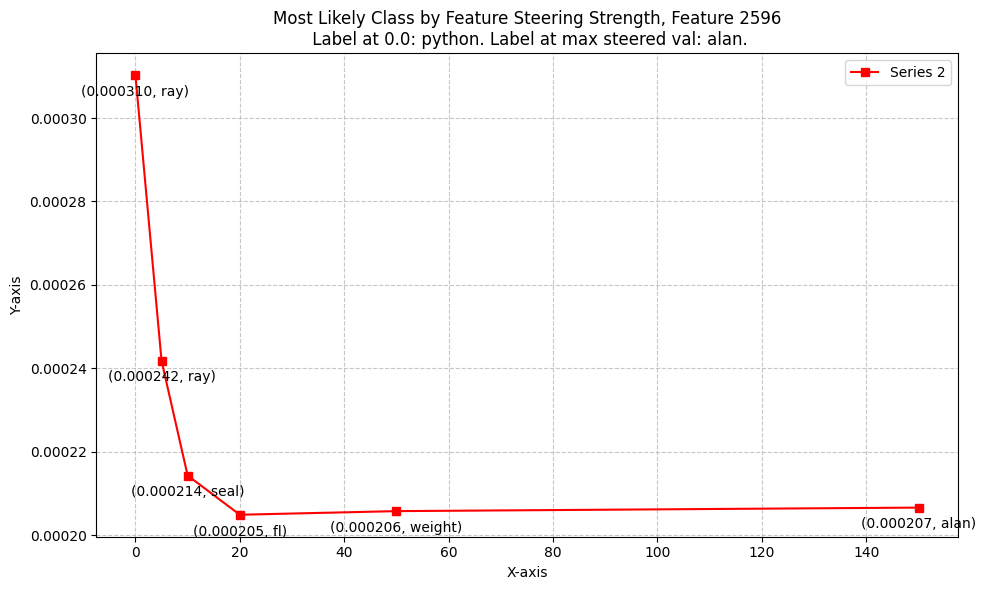

In [122]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
x = [tup[0] for tup in sorted(feat_num_concept_arr)]
y1 = [tup[1] for tup in sorted(feat_num_concept_arr)]
y2 = [tup[1] for tup in sorted(feat_num_prob_arr)]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot each line with different colors and markers
plt.plot(np.array(x), y2, 'rs-', label='Series 2')  # Red line with squares

# Label each point
for i in range(len(x)):
    # Labels for series
    plt.annotate(f'({y2[i]:01f}, {y1[i]})', 
                (x[i], y2[i]), 
                textcoords="offset points", 
                xytext=(0,-15),
                ha='center')
    
# Customize the plot
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title(f'Most Likely Class by Feature Steering Strength, Feature {feat_num}\n Label at 0.0: {steering_strength_info[0.0][0][feat_num]}. Label at max steered val: {steering_strength_info[max(list(steering_strength_info.keys()))][0][feat_num]}.')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout to prevent label overlap
plt.tight_layout()

# Show the plot
plt.show()

In [106]:
# i = 0
# for feat_num in steering_strength_info[steering_strength][0].keys():
#     print(f"=====================\nfeat_num: {feat_num}")
#     feat_num_concept_arr = []
#     feat_num_prob_arr = []
#     feat_num_ratio_arr = []
#     for key in steering_strength_info:
#         print(key, steering_strength_info[key][0][feat_num])
#         feat_num_concept_arr.append((key, steering_strength_info[key][0][feat_num]))
#         print(key, steering_strength_info[key][1][feat_num])
#         feat_num_prob_arr.append((key, steering_strength_info[key][1][feat_num].item()))
#         print(key, steering_strength_info[key][2][feat_num])
#         feat_num_ratio_arr.append((key, steering_strength_info[key][2][feat_num].item()))
#     i += 1
#     if i > 7:
#         break

### Prev Code

In [129]:
len(feature_steered_embeds[random_feat_idxs[0]])

160

In [130]:
default_embeds.shape
len(default_embeds_list)
default_embeds = torch.cat(default_embeds_list)
default_embeds.shape

torch.Size([160, 512])

In [131]:

len(altered_embeds_list), altered_embeds_list[0].shape, default_embeds.shape

(25, torch.Size([32, 512]), torch.Size([160, 512]))

In [132]:
og_model.cuda()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine

In [133]:
with open("/workspace/clip_dissect_raw.txt", "r") as f:
    larger_vocab = [line[:-1] for line in f.readlines()][:5000]

# with open("/workspace/better_img_desc.txt", "r") as f:
#     larger_vocab = [line[:-1] for line in f.readlines()][:5000]

In [134]:
# use clip vocab here and compare embeds
import torch
from PIL import Image

tokenizer = open_clip.get_tokenizer('ViT-B-32')
text = tokenizer(larger_vocab)
text_features = og_model.encode_text(text.cuda())
text_features_normed = text_features/text_features.norm(dim=-1, keepdim=True)


print(f"text_features_normed.shape: {text_features_normed.shape}")
text_probs_altered_list = []
with torch.no_grad(), torch.cuda.amp.autocast():
    for key in feature_steered_embeds:
        print(key)
        # embeds already have L2 norm of 1
        text_probs_altered = (100.0 * torch.stack(feature_steered_embeds[key]) @ text_features_normed.T).softmax(dim=-1)
        text_probs_altered_list.append(text_probs_altered)
    text_probs_default = (100.0 * default_embeds @ text_features_normed.T).softmax(dim=-1)

print("Label probs altered:", text_probs_altered.shape)  # prints: [[1., 0., 0.]]
print("Label probs default:", text_probs_default.shape)  # prints: [[1., 0., 0.]]

text_features_normed.shape: torch.Size([5000, 512])
2170
2983
615
722
2794
2814
1539
2526
1266
1285
594
143
2891
966
833
759
1337
2161
639
601
614
2902
2196
262
1125
Label probs altered: torch.Size([160, 5000])
Label probs default: torch.Size([160, 5000])


### Summed Logit Difference

In [135]:
# subtract from default, label, and print trends
text_probs_altered.shape

# selected_vocab = all_imagenet_class_names
selected_vocab = larger_vocab

top_concept_per_feat = {}
top_val_per_feat = {}
top_diff_per_feat = {}
top_ratio_per_feat = {}
# run this for sampled features over all of imagenet eval
for j, text_probs_altered in enumerate(text_probs_altered_list):
    print(f"{'============================================'*2}\n\nFor Feature {random_feat_idxs[j]}")
    print("actual image content:")
    default_vals_softmax, default_idxs_softmax = torch.topk(text_probs_default,k=10)
    print(default_vals_softmax, "\n", np.array(selected_vocab)[default_idxs_softmax.cpu()])
    
    
    logit_diff = text_probs_altered - text_probs_default
    logit_diff_aggregate = logit_diff.sum(dim=0)
    
    logit_ratio = text_probs_altered/text_probs_default
    logit_ratio_aggregate = logit_ratio.mean(dim=0)
    
    print(f"text_probs_altered.softmax(): {text_probs_altered.softmax(1).shape}")
    text_probs_altered_softmax = text_probs_altered.softmax(1)
    vals_softmax, idxs_softmax = torch.topk(text_probs_altered_softmax,k=10)
    
#     print(f"text_probs_altered.softmax(): {text_probs_altered.sum(0).softmax(0).shape}")
#     text_probs_altered_softmax_agg = text_probs_altered.sum(0).softmax(0)
#     vals_softmax_agg, idxs_softmax_agg = torch.topk(text_probs_altered_softmax_agg,k=10)
    
    print(f"\nSoftmax Over {text_probs_altered.shape[0]} Images:\n{vals_softmax}")
    print(np.array(selected_vocab)[idxs_softmax.cpu()])
    for i in range(vals_softmax.shape[0]):
        print(vals_softmax[i], "\n", np.array(selected_vocab)[idxs_softmax.cpu()][i])
        break
        
#     print(f"\nAgg Softmax Over {text_probs_altered.shape[0]} Images:\n{vals_softmax_agg}")
#     print(np.array(selected_vocab)[idxs_softmax_agg.cpu()])
    
    vals_agg, idxs_agg = torch.topk(logit_diff_aggregate,k=10)
    vals_least_agg, idxs_least_agg = torch.topk(logit_diff_aggregate,k=10,largest=False)
    
    ratios_agg, ratios_idxs_agg = torch.topk(logit_ratio_aggregate,k=10)
    ratios_least_agg, ratios_idxs_least_agg = torch.topk(logit_ratio_aggregate,k=10,largest=False)
    
    vals, idxs = torch.topk(logit_diff,k=5)
    vals_least, idxs_least = torch.topk(logit_diff,k=5,largest=False)
    
    ratios, ratios_idxs = torch.topk(logit_ratio,k=5)
    ratios_least, ratios_idxs_least = torch.topk(logit_ratio,k=5,largest=False)
    
    top_concept_per_feat[random_feat_idxs[j]] = np.array(selected_vocab)[idxs_softmax.cpu()][0][0]
    top_val_per_feat[random_feat_idxs[j]] = vals_softmax[0][0]
    top_diff_per_feat[random_feat_idxs[j]] = vals_agg[0]
    top_ratio_per_feat[random_feat_idxs[j]] = ratios_agg[0]
    
    
    print(f"\nMost Changed, by Absolute Diff Over {logit_diff.shape[0]} Images:\n{vals_agg}")
    print(np.array(selected_vocab)[idxs_agg.cpu()])
    print(vals_least_agg)
    print(np.array(selected_vocab)[idxs_least_agg.cpu()])
    
    print(f"\nMost Changed, by Ratio Over {logit_diff.shape[0]} Images:")
    print(ratios_agg)
    print(np.array(selected_vocab)[ratios_idxs_agg.cpu()])
    print(vals_least_agg)
    print(np.array(selected_vocab)[ratios_idxs_least_agg.cpu()])


For Feature 2170
actual image content:
tensor([[0.5584, 0.1575, 0.0111,  ..., 0.0055, 0.0047, 0.0047],
        [0.7183, 0.0722, 0.0352,  ..., 0.0058, 0.0052, 0.0032],
        [0.1819, 0.1020, 0.0770,  ..., 0.0177, 0.0175, 0.0159],
        ...,
        [0.8843, 0.0097, 0.0054,  ..., 0.0026, 0.0025, 0.0024],
        [0.1088, 0.0630, 0.0610,  ..., 0.0279, 0.0228, 0.0208],
        [0.5017, 0.0581, 0.0283,  ..., 0.0116, 0.0101, 0.0098]],
       device='cuda:0') 
 [['python' 'debian' 's' ... 'rubber' 'male' 'rolling']
 ['ski' 'sequence' 'trembl' ... 'turns' 'board' 'pair']
 ['dog' 'golden' 'adopted' ... 'pussy' 'douglas' 'charles']
 ...
 ['gun' 'thompson' 'model' ... 'shown' 'lower' 'shooting']
 ['tables' 'boards' 'table' ... 'hall' 'sit' 'before']
 ['gardens' 'square' 'park' ... 'lens' 'campus' 'photo']]
text_probs_altered.softmax(): torch.Size([160, 5000])

Softmax Over 160 Images:
tensor([[0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        [0.0002, 0.0002, 0.0002,  ..., 0.000

tensor([-2.3870, -2.0345, -1.7244, -1.5903, -1.4886, -1.2999, -1.2828, -1.1973,
        -1.1892, -1.1612], device='cuda:0')
['disclosure' 'perl' 'vary' 'spyware' 'barbara' 'dakota' 'taylor'
 'partial' 'indicate' 'quarter']

For Feature 833
actual image content:
tensor([[0.5584, 0.1575, 0.0111,  ..., 0.0055, 0.0047, 0.0047],
        [0.7183, 0.0722, 0.0352,  ..., 0.0058, 0.0052, 0.0032],
        [0.1819, 0.1020, 0.0770,  ..., 0.0177, 0.0175, 0.0159],
        ...,
        [0.8843, 0.0097, 0.0054,  ..., 0.0026, 0.0025, 0.0024],
        [0.1088, 0.0630, 0.0610,  ..., 0.0279, 0.0228, 0.0208],
        [0.5017, 0.0581, 0.0283,  ..., 0.0116, 0.0101, 0.0098]],
       device='cuda:0') 
 [['python' 'debian' 's' ... 'rubber' 'male' 'rolling']
 ['ski' 'sequence' 'trembl' ... 'turns' 'board' 'pair']
 ['dog' 'golden' 'adopted' ... 'pussy' 'douglas' 'charles']
 ...
 ['gun' 'thompson' 'model' ... 'shown' 'lower' 'shooting']
 ['tables' 'boards' 'table' ... 'hall' 'sit' 'before']
 ['gardens' 'square' 'pa

In [136]:
top_concept_per_feat,top_val_per_feat,top_ratio_per_feat

({2170: 'poll',
  2983: 'instruments',
  615: 'nfl',
  722: 'pair',
  2794: 'icon',
  2814: 'relief',
  1539: 'specifications',
  2526: 'pet',
  1266: 'turkey',
  1285: 'football',
  594: 'adapter',
  143: 'louisiana',
  2891: 'outdoor',
  966: 'cases',
  833: 'toy',
  759: 'buttons',
  1337: 'sd',
  2161: 'bulk',
  639: 'baltimore',
  601: 'jersey',
  614: 'recipe',
  2902: 'scotland',
  2196: 'louisiana',
  262: 'quotes',
  1125: 'shown'},
 {2170: tensor(0.0002, device='cuda:0'),
  2983: tensor(0.0003, device='cuda:0'),
  615: tensor(0.0002, device='cuda:0'),
  722: tensor(0.0002, device='cuda:0'),
  2794: tensor(0.0002, device='cuda:0'),
  2814: tensor(0.0002, device='cuda:0'),
  1539: tensor(0.0002, device='cuda:0'),
  2526: tensor(0.0002, device='cuda:0'),
  1266: tensor(0.0002, device='cuda:0'),
  1285: tensor(0.0002, device='cuda:0'),
  594: tensor(0.0002, device='cuda:0'),
  143: tensor(0.0002, device='cuda:0'),
  2891: tensor(0.0002, device='cuda:0'),
  966: tensor(0.0002, dev

In [137]:
steering_strength_info = {}
steering_strength_info[steering_strength] = (top_concept_per_feat,top_val_per_feat,top_ratio_per_feat,top_diff_per_feat)


In [138]:
steering_strength_info[steering_strength][0].keys()

dict_keys([2170, 2983, 615, 722, 2794, 2814, 1539, 2526, 1266, 1285, 594, 143, 2891, 966, 833, 759, 1337, 2161, 639, 601, 614, 2902, 2196, 262, 1125])

In [139]:
steering_strength_info

{0.0: ({166: 'python',
   2690: 'python',
   2031: 'python',
   1413: 'python',
   835: 'python',
   2541: 'python',
   2605: 'python',
   2833: 'python',
   388: 'python',
   138: 'python',
   2436: 'python',
   1804: 'python',
   1191: 'python',
   2741: 'python',
   2545: 'python',
   452: 'python',
   2183: 'python',
   905: 'python',
   2125: 'python',
   2693: 'python',
   2298: 'python',
   1548: 'python',
   2395: 'python',
   1175: 'python',
   1356: 'python'},
  {166: tensor(0.0003, device='cuda:0'),
   2690: tensor(0.0003, device='cuda:0'),
   2031: tensor(0.0003, device='cuda:0'),
   1413: tensor(0.0003, device='cuda:0'),
   835: tensor(0.0003, device='cuda:0'),
   2541: tensor(0.0003, device='cuda:0'),
   2605: tensor(0.0003, device='cuda:0'),
   2833: tensor(0.0003, device='cuda:0'),
   388: tensor(0.0003, device='cuda:0'),
   138: tensor(0.0003, device='cuda:0'),
   2436: tensor(0.0003, device='cuda:0'),
   1804: tensor(0.0003, device='cuda:0'),
   1191: tensor(0.0003, d

In [140]:
i = 0
for feat_num in steering_strength_info[steering_strength][0].keys():
    print(f"=====================\nfeat_num: {feat_num}")
    feat_num_concept_arr = []
    feat_num_prob_arr = []
    feat_num_ratio_arr = []
    for key in steering_strength_info:
        print(key, steering_strength_info[key][0][feat_num])
        feat_num_concept_arr.append((key, steering_strength_info[key][0][feat_num]))
        print(key, steering_strength_info[key][1][feat_num])
        feat_num_prob_arr.append((key, steering_strength_info[key][1][feat_num].item()))
        print(key, steering_strength_info[key][2][feat_num])
        feat_num_ratio_arr.append((key, steering_strength_info[key][2][feat_num].item()))
    i += 1
    if i > 5:
        break

feat_num: 2170


KeyError: 2170

In [ ]:
sorted(feat_num_concept_arr),sorted(feat_num_prob_arr),sorted(feat_num_ratio_arr),

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
x = [tup[0] for tup in sorted(feat_num_concept_arr)]
y1 = [tup[1] for tup in sorted(feat_num_concept_arr)]
y2 = [tup[1] for tup in sorted(feat_num_prob_arr)]
# y3 = [tup[1] for tup in sorted(feat_num_ratio_arr)]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot each line with different colors and markers
# plt.plot(x, y1, 'bo-', label='Series 1')  # Blue line with circles
plt.plot(np.array(x), y2, 'rs-', label='Series 2')  # Red line with squares
# plt.plot(x, y3, 'gd-', label='Series 3')  # Green line with diamonds

# Label each point for all three series
for i in range(len(x)):
#     # Labels for series 1
#     plt.annotate(f'({x[i]}, {y1[i]})', 
#                 (x[i], y1[i]), 
#                 textcoords="offset points", 
#                 xytext=(0,10),
#                 ha='center')
    
    # Labels for series 2
    plt.annotate(f'({y2[i]:01f}, {y1[i]})', 
                (x[i], y2[i]), 
                textcoords="offset points", 
                xytext=(0,-15),
                ha='center')
    
#     # Labels for series 3
#     plt.annotate(f'({x[i]}, {y3[i]})', 
#                 (x[i], y3[i]), 
#                 textcoords="offset points", 
#                 xytext=(0,10),
#                 ha='center')

# Customize the plot
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title(f'Most Likely Class by Feature Steering Strength, Feature {feat_num}\n Label at 0.0: {steering_strength_info[0.0][0][feat_num]}. Label at max steered val: {steering_strength_info[max(list(steering_strength_info.keys()))][0][feat_num]}.')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout to prevent label overlap
plt.tight_layout()

# Show the plot
plt.show()

## Enc/Dec Clustering/Exploration

In [224]:
encoder_weights_for_math = sparse_autoencoder.W_enc
decoder_weights_for_math = sparse_autoencoder.W_dec

In [261]:
dists_from_feat_0 = encoder_weights_for_math[0] - encoder_weights_for_math

In [279]:
dists_from_feat_0_normalized = encoder_weights_for_math[0]/encoder_weights_for_math[0].norm(p=2) - encoder_weights_for_math/encoder_weights_for_math.norm(p=2,dim=0)

In [262]:
dists_from_feat_0.norm(p=2, dim=0).shape

torch.Size([49152])

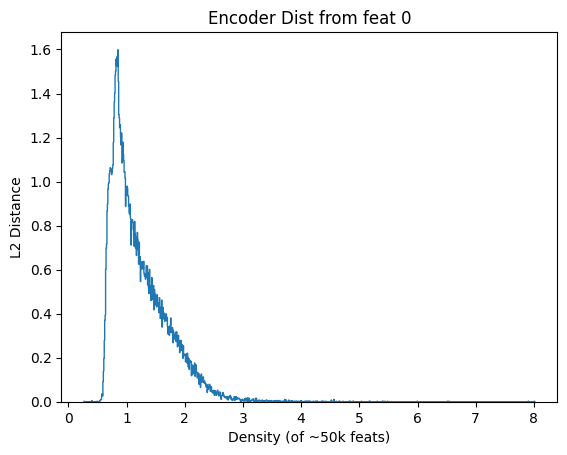

In [280]:
# plt.hist(bins[:-1], bins)
plt.hist(dists_from_feat_0.norm(p=2, dim=0).cpu(), density=True, bins=1000, histtype='step')  # density=False would make counts
plt.title('Encoder Dist from feat 0')
plt.ylabel('L2 Distance')
plt.xlabel('Density (of ~50k feats)');


In [222]:
torch.topk(dists_from_feat_0.norm(p=2, dim=0),k=10,largest=False)

torch.return_types.topk(
values=tensor([0.2669, 0.3993, 0.4042, 0.4919, 0.5330, 0.5413, 0.5465, 0.5468, 0.5490,
        0.5538], device='cuda:0'),
indices=tensor([ 9777, 19829, 14140, 24701, 17384, 44489, 47300, 45112,  5297, 15368],
       device='cuda:0'))

In [281]:
dec_dists_from_feat_0 = decoder_weights_for_math[0]/decoder_weights_for_math[0].norm(p=2) - decoder_weights_for_math/decoder_weights_for_math.norm(p=2)
dec_dists_from_feat_0.shape

torch.Size([49152, 768])

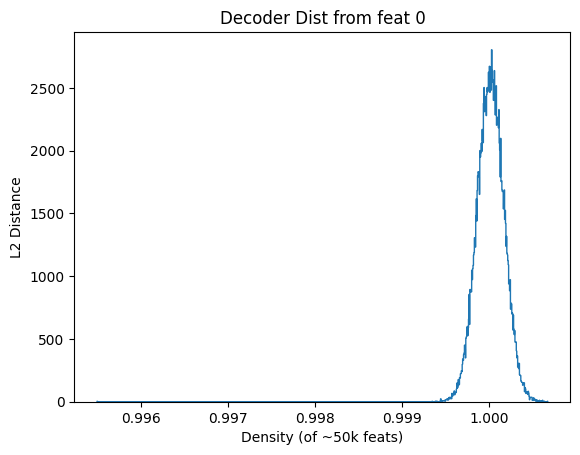

In [282]:
# plt.hist(bins[:-1], bins)
plt.hist(dec_dists_from_feat_0.T.norm(p=2, dim=0).cpu(), density=True, bins=1000, histtype='step')  # density=False would make counts
plt.title('Decoder Dist from feat 0')
plt.ylabel('L2 Distance')
plt.xlabel('Density (of ~50k feats)');


In [248]:
torch.topk(dec_dists_from_feat_0.T.norm(p=2, dim=0),k=10,largest=False)

torch.return_types.topk(
values=tensor([0.0000, 1.3056, 1.3120, 1.3134, 1.3155, 1.3209, 1.3221, 1.3221, 1.3222,
        1.3227], device='cuda:0'),
indices=tensor([    0,  3256, 22171, 39781, 28196, 34233, 26573, 34134, 13175, 34499],
       device='cuda:0'))

In [247]:
dec_dists_from_feat_0.T.norm(p=2, dim=0).shape

torch.Size([49152])